In [ ]:
from google.colab import files
uploaded = files.upload()

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
countries = pd.read_csv("drive/My Drive/airbnb-new-user/countries.csv")
age_gender = pd.read_csv("drive/My Drive/airbnb-new-user/age_gender_bkts.csv")
test = pd.read_csv("drive/My Drive/airbnb-new-user/test.csv")
samp = pd.read_csv("drive/My Drive/airbnb-new-user/sample_submission_NDGC_3.csv")
session = pd.read_csv("drive/My Drive/airbnb-new-user/sessions.csv")
train = pd.read_csv("drive/My Drive/airbnb-new-user/train.csv")

# EDA and Preprocessing(Oulier and null value handling)

## Age, Gender, Population of Countries

First to get the ages in sorted order, we take the mean of the age ranges, so that any ages in the range are closer to the mean

In [ ]:
from functools import reduce
age_gender["age_avg"] = age_gender.age_bucket.apply(lambda x: 102 if x=="100+" else reduce(lambda a, b: (int(a)+int(b))/2, x.split("-")))
age_gender.drop(columns=["age_bucket"], inplace=True)

Group by country destination and age

In [ ]:
grp_age_ctr = age_gender[["country_destination",'population_in_thousands', "age_avg"]].groupby(["country_destination", "age_avg"]).sum().reset_index(level=0).reset_index(level=0)

#### Age vs population for different countries

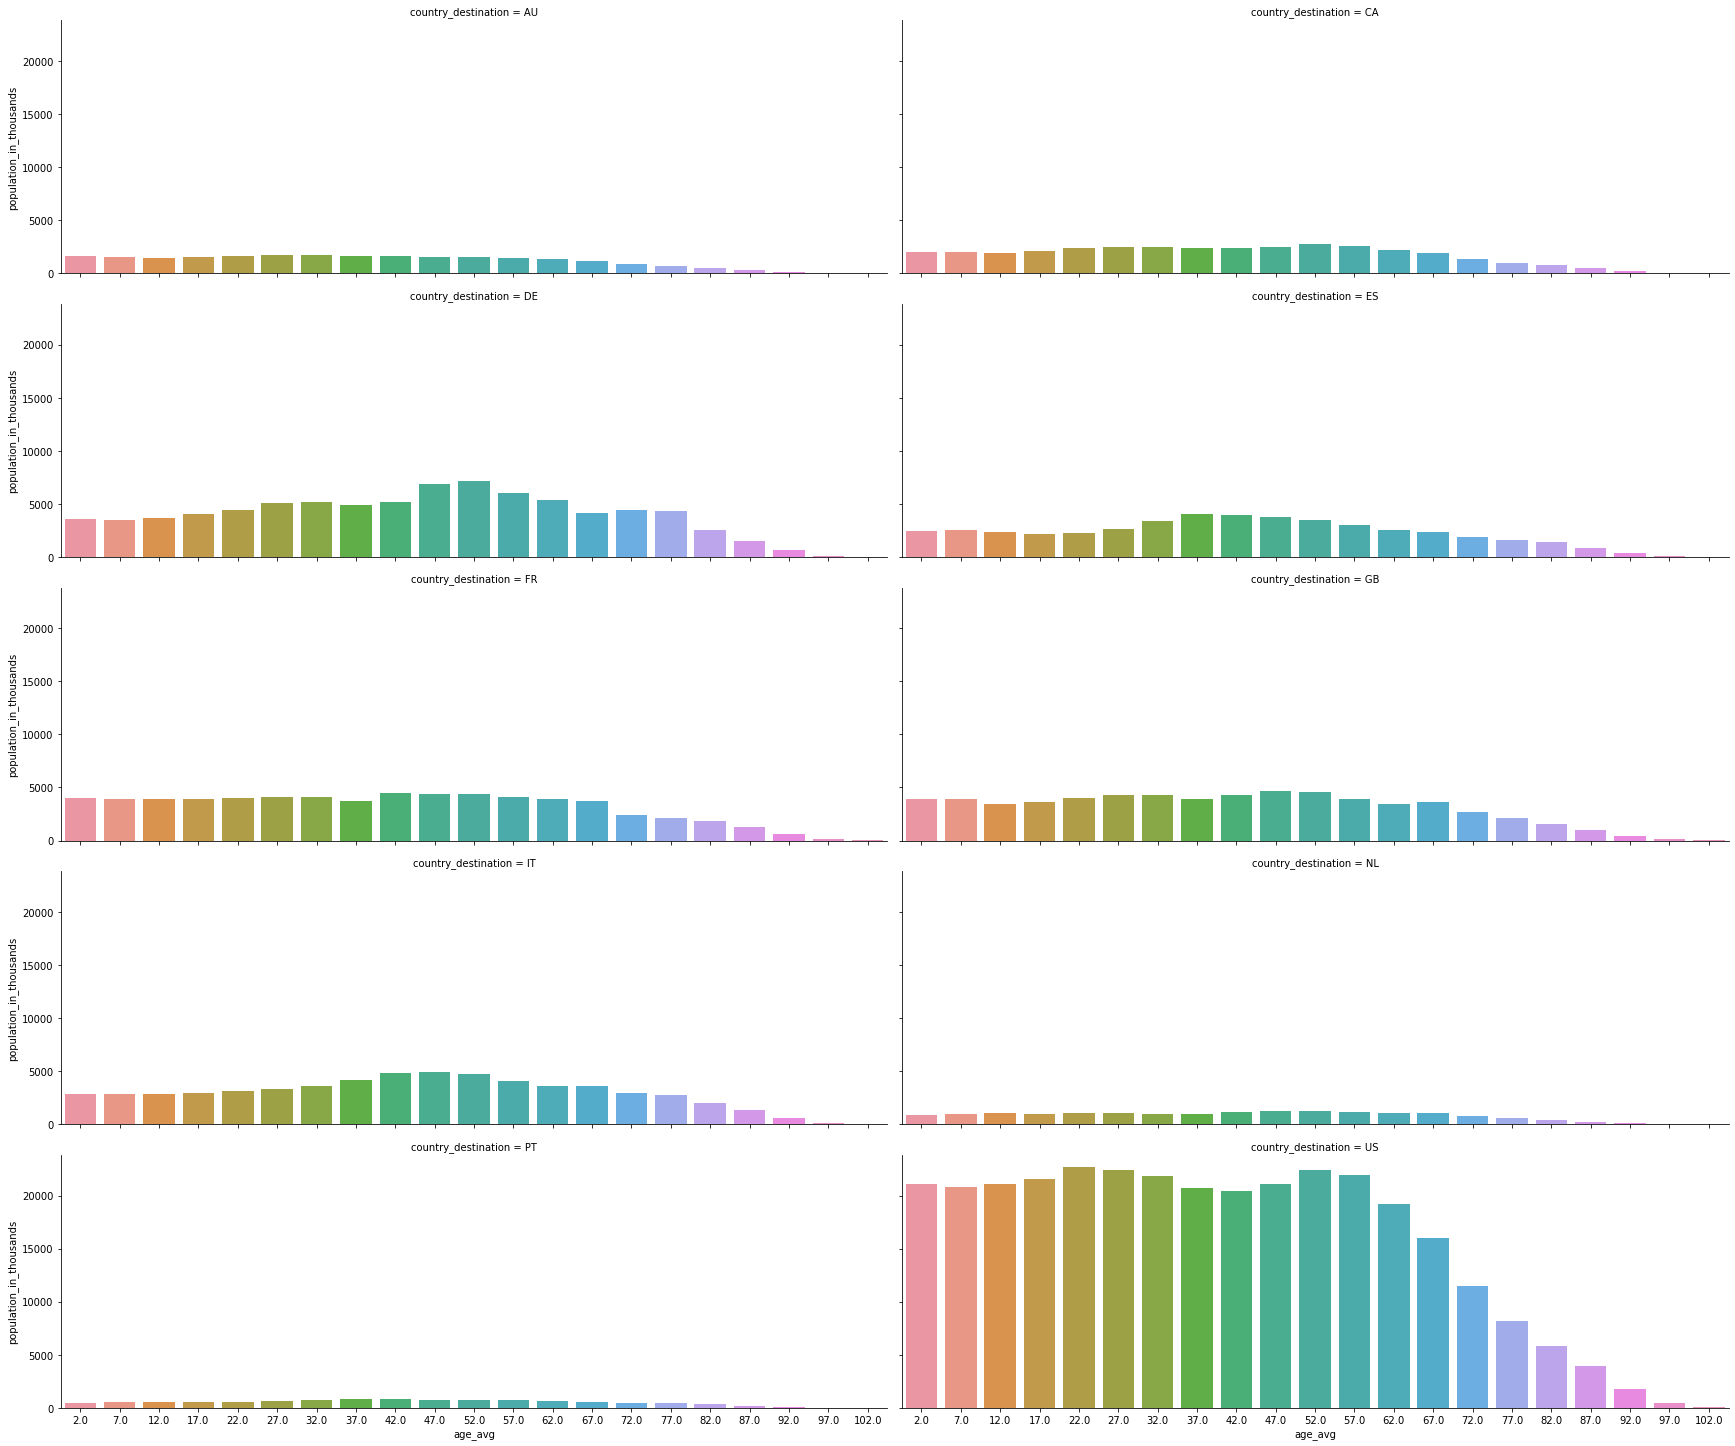

In [ ]:
sns.catplot(data=grp_age_ctr, x="age_avg", y="population_in_thousands", kind="bar", col="country_destination", col_wrap=2, height=4, aspect=3)

All the countries have a similar age distribution with people in 40-50 being the majority

#### Country vs Population for different Ages

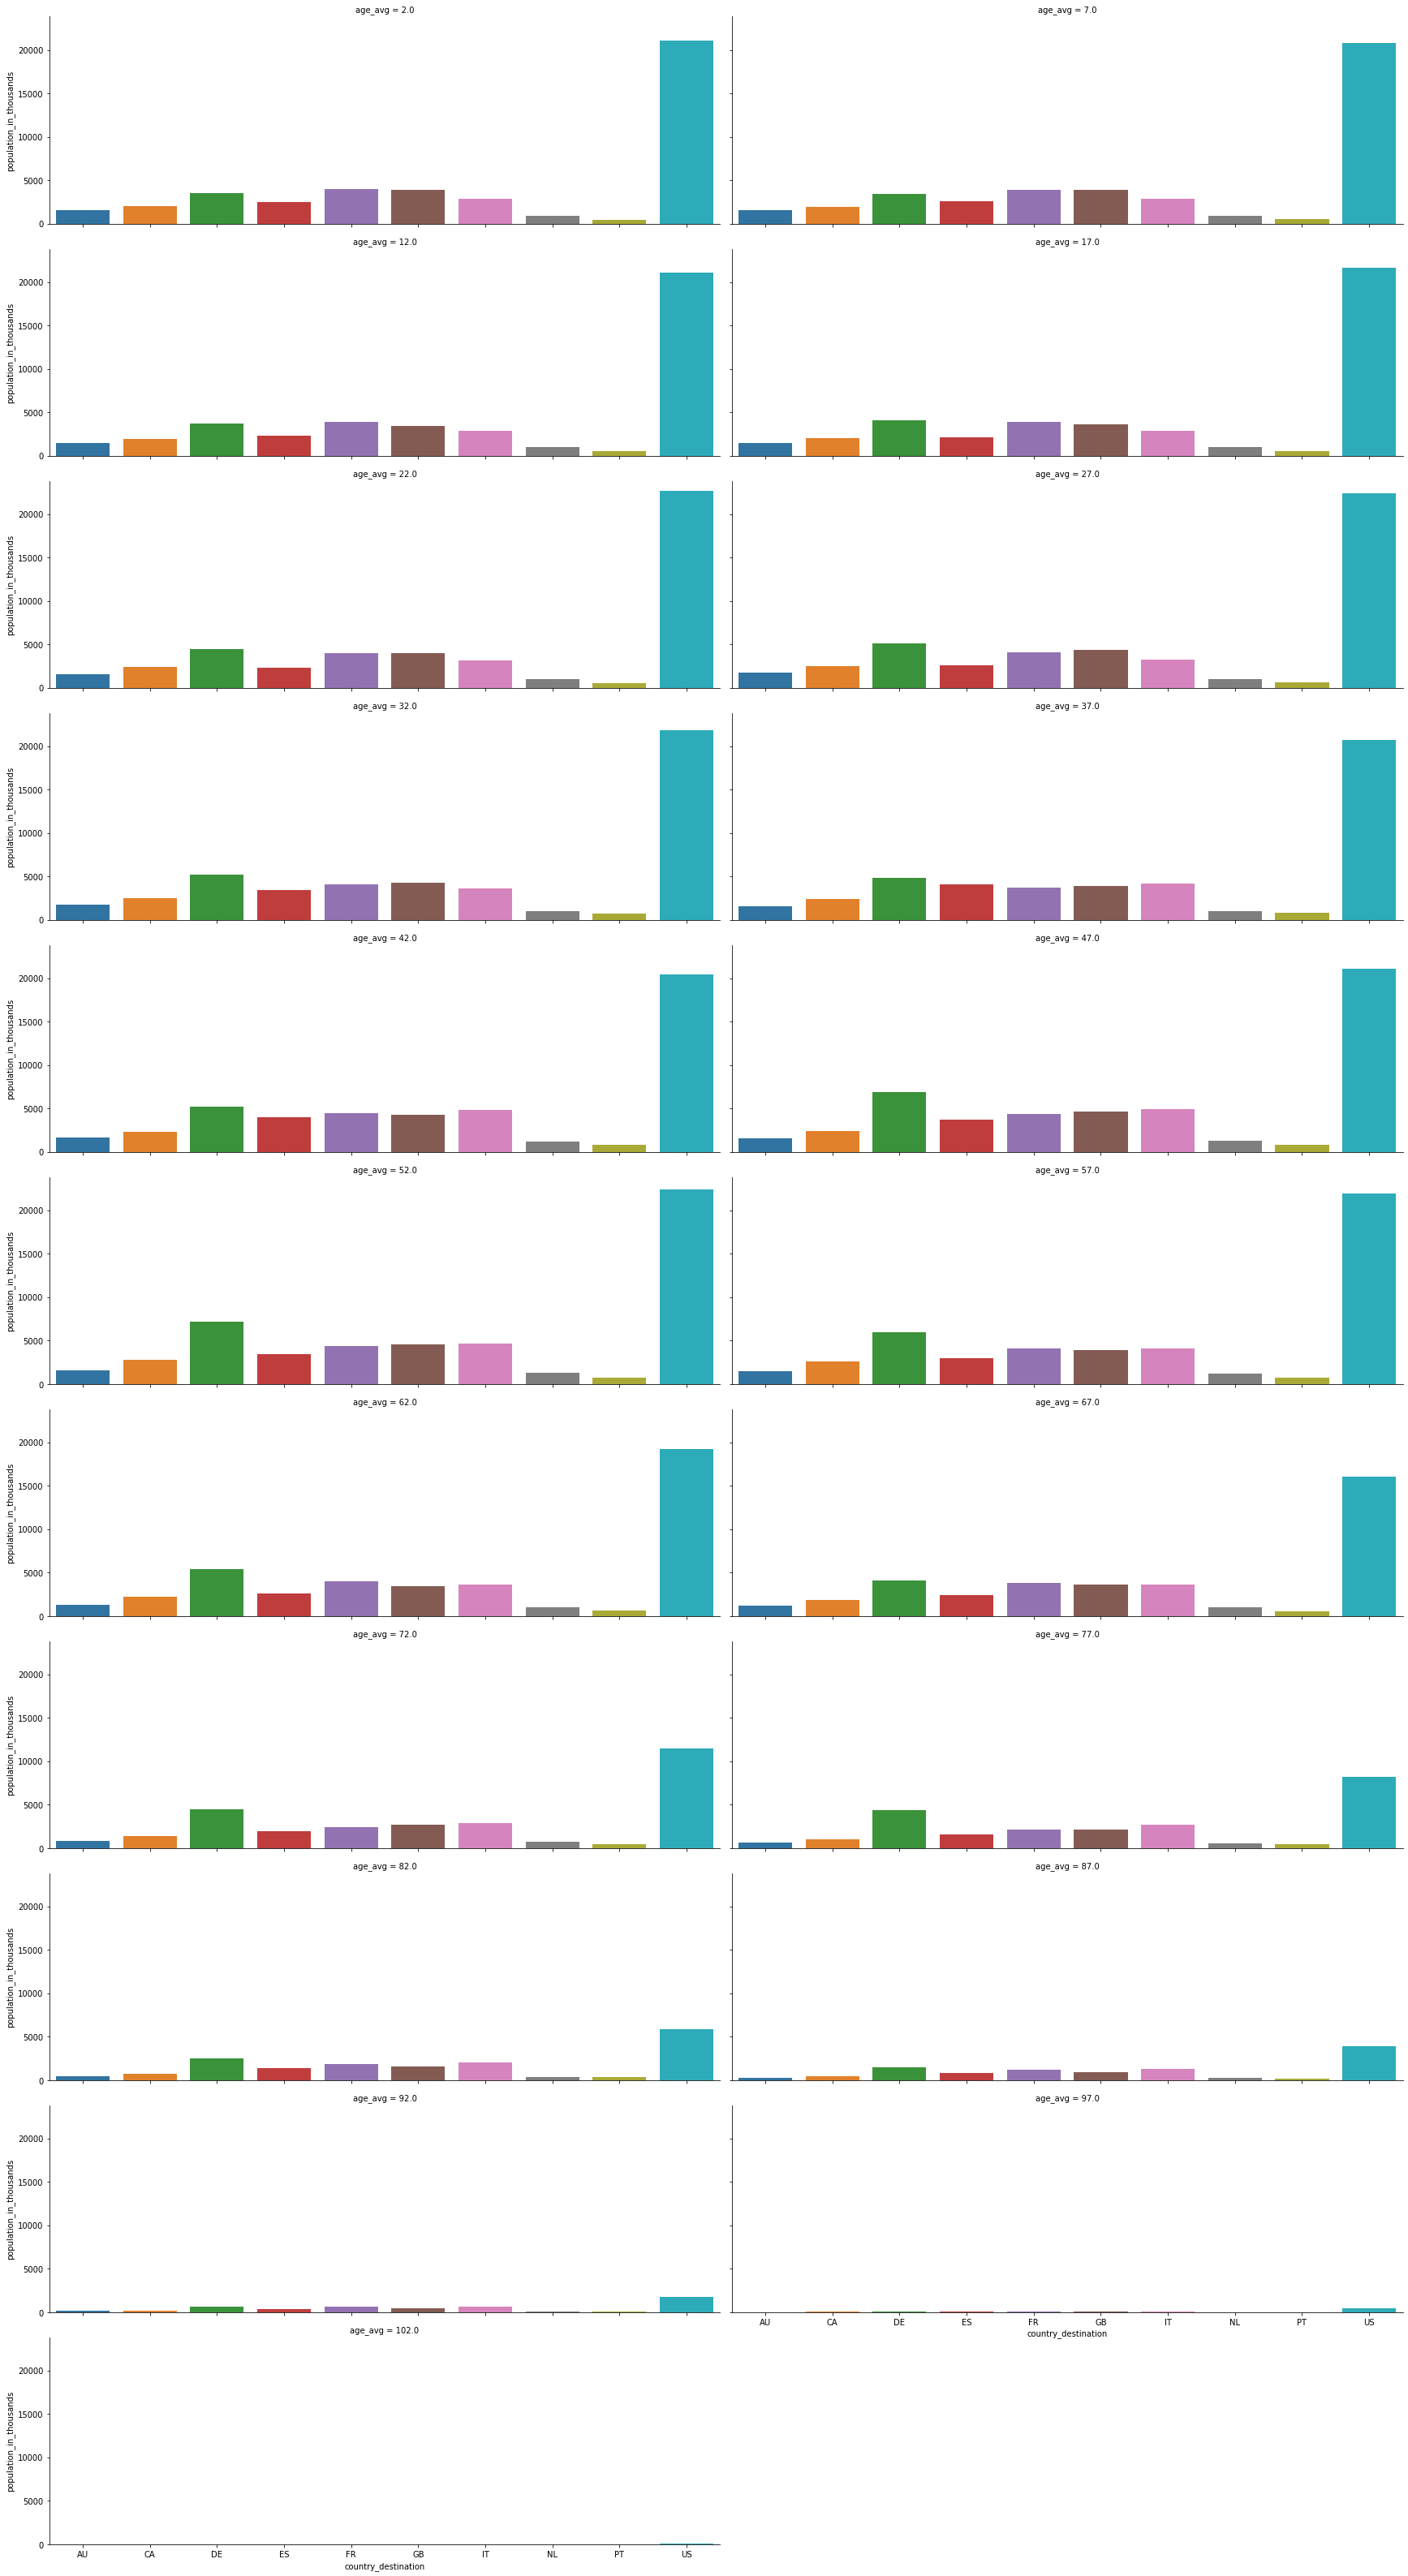

In [ ]:
sns.catplot(data=grp_age_ctr, x="country_destination", y="population_in_thousands", kind="bar", col="age_avg", col_wrap=2, height=4, aspect=3)

All ages follow a similar distribution, with US being the most and Portugal being the least. People of ages 100+ are only present in the US

#### Age vs Population

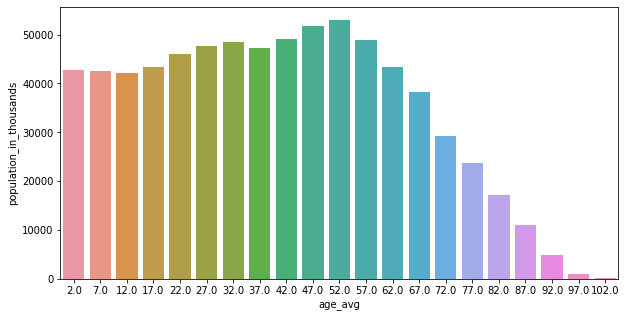

In [ ]:
age_pop = age_gender.groupby("age_avg").sum().reset_index()
plt.figure(figsize=(10, 5))
sns.barplot(x="age_avg", y="population_in_thousands", data=age_pop)

People from ages 50-54 are the most and people almost steadily increase till 50-54 and go down from there rapidly.

#### Country vs population

Population in each country:

In [ ]:
cr_pop = age_gender.groupby("country_destination").sum()
(cr_pop.population_in_thousands/cr_pop.population_in_thousands.sum() * 100).sort_values(ascending=False)

country_destination
US    44.409902
DE    11.277175
FR     8.876052
GB     8.719930
IT     8.351819
ES     6.447476
CA     4.899633
AU     3.267652
NL     2.301275
PT     1.449087
Name: population_in_thousands, dtype: float64

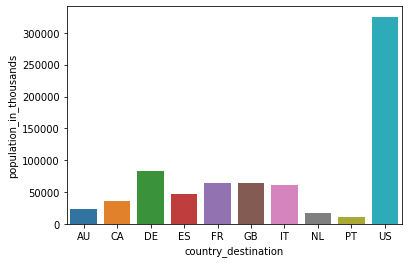

In [ ]:
sns.barplot(x=cr_pop.index, y="population_in_thousands", data=cr_pop)

US has the most population, followed by Germany

#### Gender

    gender country_destination  population_in_thousands     year  age_avg
9   female                  US                 165053.0  42315.0   1092.0
19    male                  US                 160079.0  42315.0   1092.0
2   female                  DE                  41997.0  42315.0   1092.0
12    male                  DE                  40565.0  42315.0   1092.0
4   female                  FR                  33493.0  42315.0   1092.0
5   female                  GB                  32345.0  42315.0   1092.0
15    male                  GB                  31495.0  42315.0   1092.0
14    male                  FR                  31490.0  42315.0   1092.0
6   female                  IT                  31405.0  42315.0   1092.0
16    male                  IT                  29740.0  42315.0   1092.0
3   female                  ES                  23870.0  42315.0   1092.0
13    male                  ES                  23333.0  42315.0   1092.0
1   female                  CA        

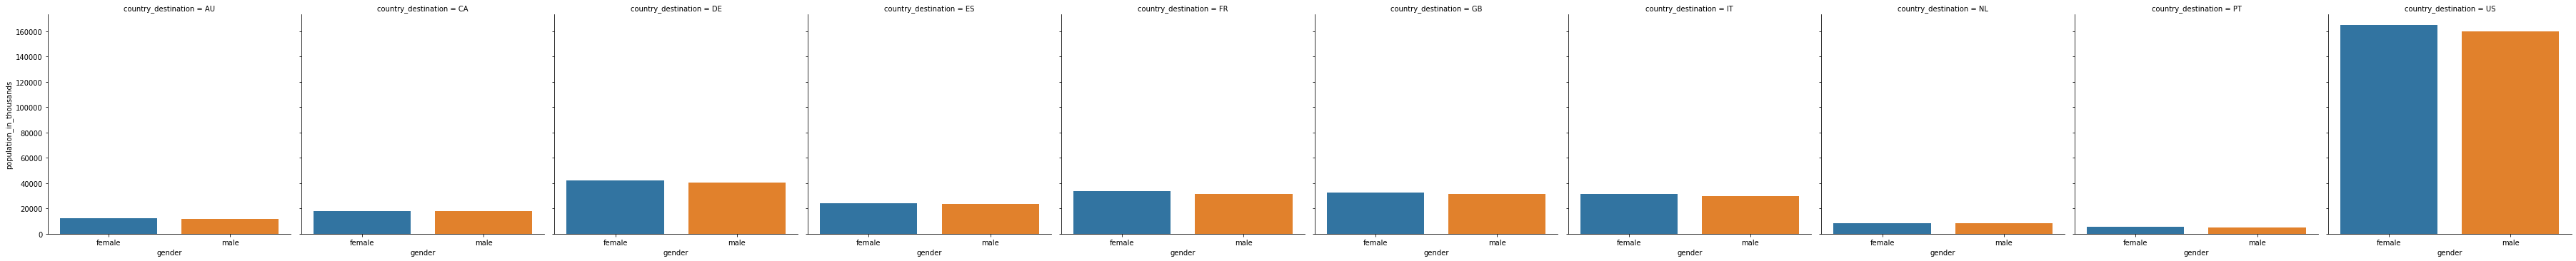

In [ ]:
gender_gp = age_gender.groupby(["gender", "country_destination"]).sum().reset_index()
print(gender_gp.sort_values(by="population_in_thousands", ascending=False))
sns.catplot(x="gender", y="population_in_thousands", data=gender_gp, kind="bar", col="country_destination")

Per country, there is no noticiable female-male difference 

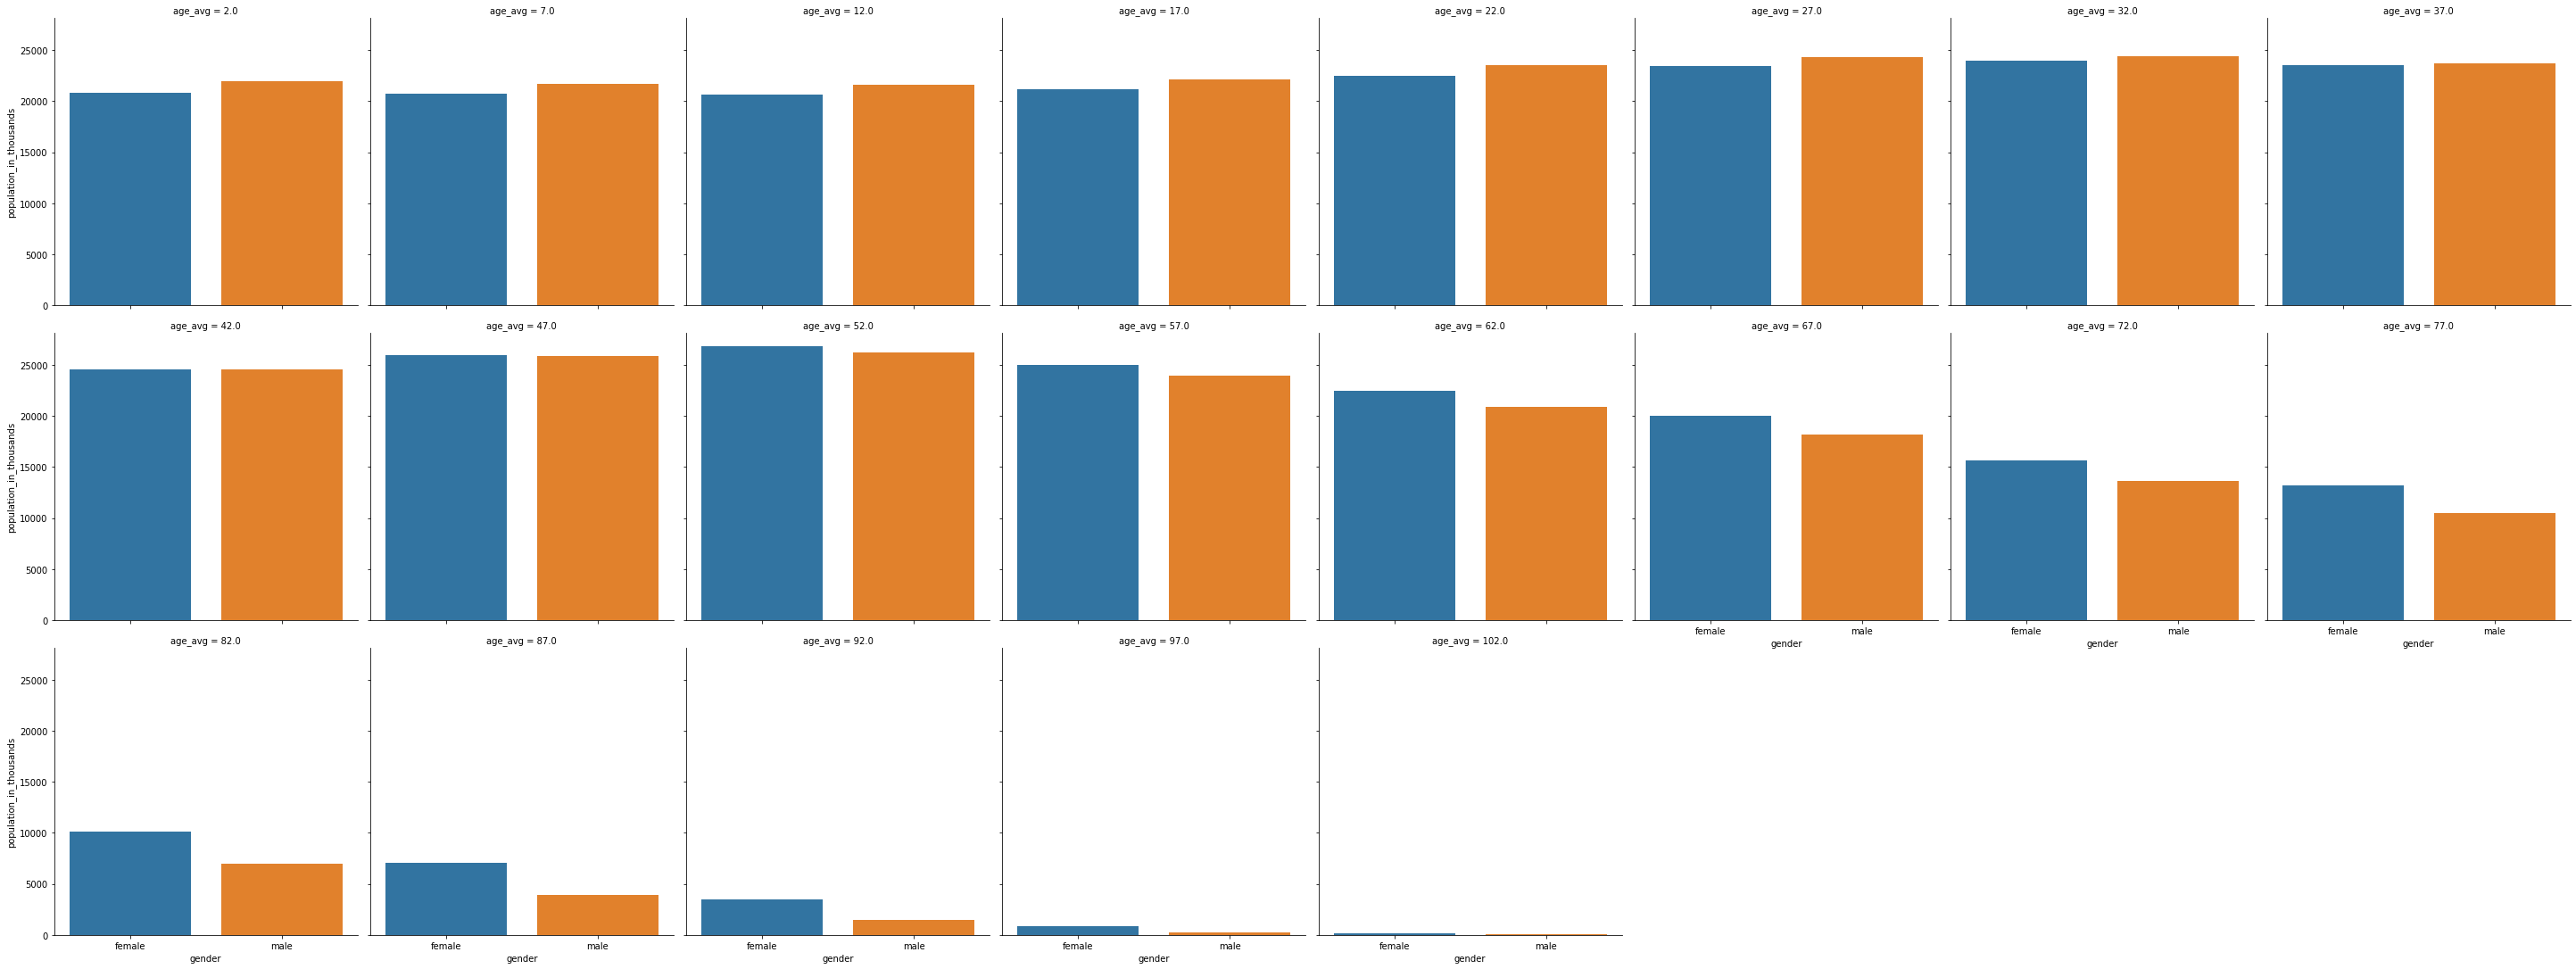

In [ ]:
gender_gp = age_gender.groupby(["gender", "age_avg"]).sum().reset_index()
sns.catplot(x="gender", y="population_in_thousands", data=gender_gp, kind="bar", col="age_avg", col_wrap=8)

Till age group of 35-40, there are more men compared to women. From 40-45, there are more women compared to men. There are more younger men than women. Meaning, female life expectancy is higher than men

## Data handling

Splitting into input features and combining them for imputing and analysing. Extra column "train" is added to identify training set in the future

In [5]:
# X_train = train.drop("country_destination", axis=1)
# X_test = test.copy()
# Y_train = train["country_destination"]

train["train"] = 1
test["train"] = 0


tot = pd.concat([train, test], axis=0, ignore_index=True)

Before analysing the data, we need to handle outliers in training dataset

### Outlier Handling

#### Age

We have to impute train data based on train data alone and test data based on test data alone

In [6]:
test.age

0         NaN
1        22.0
2        36.0
3        52.0
4        51.0
         ... 
43309    32.0
43310     NaN
43311    32.0
43312     NaN
43313     NaN
Name: age, Length: 43314, dtype: float64

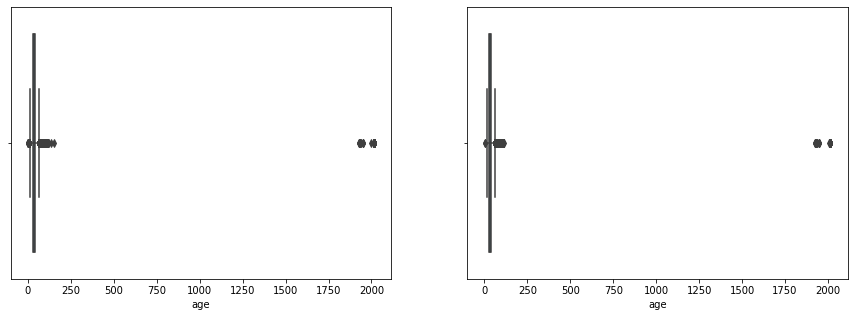

In [7]:
f, a = plt.subplots(1, 2, figsize=(15, 5))
p1 = sns.boxplot(x="age", data=train, ax=a[0])
p2 = sns.boxplot(x="age", data=test, ax=a[1])
# p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
# p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

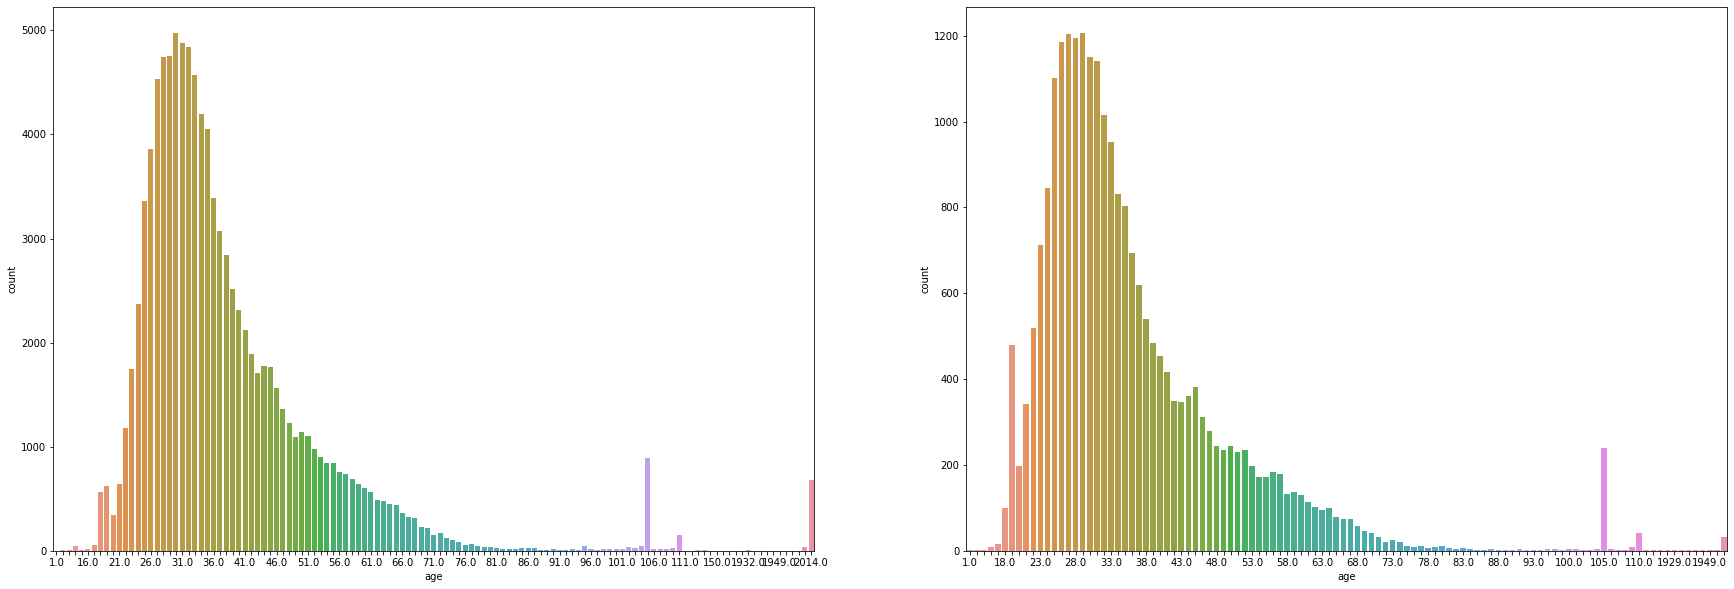

In [8]:
f, a = plt.subplots(1, 2, figsize=(30, 10))
p1 = sns.countplot(x="age", data=train, ax=a[0])
p2 = sns.countplot(x="age", data=test, ax=a[1])
for ind, label in enumerate(p1.get_xticklabels()):
    if ind % 5 == 0:  # every 100th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
for ind, label in enumerate(p2.get_xticklabels()):
    if ind % 5 == 0:  # every 100th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

The outliers here are errors as the ages of 1900s are not real. These are not really "outliers" in the data and hence can be replaced by corresponding medians of train and test data

In [9]:
q1_train = train.age.quantile(q = 0.25)
q3_train = train.age.quantile(q = 0.75)
iqr_train = q3_train - q1_train
outlier_range_train = 1.5*iqr_train
r_whisker_train = q3_train + outlier_range_train
l_whisker_train = q1_train - outlier_range_train
print(r_whisker_train)

q1_test = test.age.quantile(q = 0.25)
q3_test = test.age.quantile(q = 0.75)
iqr_test = q3_test - q1_test
outlier_range_test = 1.5*iqr_test
r_whisker_test = q3_test + outlier_range_test
l_whisker_test = q1_test - outlier_range_test

print(r_whisker_test)

64.0
62.0


We can include the outliers greater than the right whisker as people of those ages are a part of the data. For the ones that are greater than 120(oldest person alive age), we replace the ages with the median.

In [10]:
age_median_train = train.age.median()
age_median_test = test.age.median()
def replace_outliers(x, med):
    if x > 120:
        return med
    else:
        return x

In [11]:
train.age = train.age.apply(lambda x: replace_outliers(x, age_median_train))
test.age = test.age.apply(lambda x: replace_outliers(x, age_median_test))

### Handling missing values

#### Age

##### In training data

In [12]:
train.isna().sum().age

68769

In [13]:
train.groupby("gender").agg(np.median).age

gender
-unknown-    35.0
FEMALE       34.0
MALE         34.0
OTHER        35.0
Name: age, dtype: float64

Gender doesn't capture the diversity of the data set.

In [14]:
train.groupby(["affiliate_channel", "affiliate_provider"]).agg(np.median)[["age"]]

age
affiliate_channel affiliate_provider       
api               other                31.0
content           facebook             45.0
                  google               37.0
                  gsp                  42.0
                  other                37.0
direct            direct               34.0
                  other                35.0
other             craigslist           35.0
                  email-marketing      35.0
                  facebook-open-graph  37.0
                  meetup               31.0
                  other                34.0
                  padmapper            28.0
                  wayn                 48.0
remarketing       google               36.0
                  yandex               34.0
sem-brand         baidu                26.0
                  bing                 43.0
                  google               37.0
                  naver                32.0
                  other                37.0
                  yandex               33.5
sem-non-brand     baidu                27.0
                  bing                 48.0
                  facebook             54.5
                  google               37.0
                  naver                29.0
                  other                38.0
                  vast                 41.0
                  yandex               25.0
seo               baidu                28.0
                  bing                 41.0
                  facebook             29.0
                  google               32.0
                  other                33.0
                  yahoo                45.0

Affiliate channel and affiliate provider seem to better describe the age of the user. We fill age nan values with the group median. 

In [15]:
train.age = train.groupby(["affiliate_channel", "affiliate_provider"])["age"].apply(lambda x: x.fillna(x.median()))

##### In test data

In [16]:
test.isna().sum().age

19221

In [17]:
test.groupby("gender").agg(np.median).age

gender
-unknown-    34.0
FEMALE       31.0
MALE         32.0
OTHER        30.5
Name: age, dtype: float64

Gender doesn't capture the diversity of the data set.

In [18]:
test.groupby(["affiliate_channel", "affiliate_provider"]).agg(np.median)[["age"]]

age
affiliate_channel affiliate_provider       
api               other                31.0
content           facebook             32.5
                  google               37.5
                  gsp                  57.0
                  other                27.5
                  yandex                NaN
direct            direct               31.0
other             craigslist           29.0
                  email-marketing      35.0
                  facebook-open-graph  33.5
                  meetup               29.0
                  other                31.0
                  padmapper            28.0
remarketing       google               34.5
                  yandex               39.0
sem-brand         baidu                24.0
                  bing                 40.0
                  google               34.0
                  naver                 NaN
                  other                31.0
                  yandex               30.5
sem-non-brand     baidu                 NaN
                  bing                 44.0
                  daum                  NaN
                  google               36.0
                  naver                38.0
                  other                25.0
                  yandex               34.0
seo               baidu                24.0
                  bing                 45.0
                  facebook             27.0
                  google               31.0
                  other                35.0
                  yahoo                37.0

This does capture the different ranges of ages for different affiliate providers and affiliate channels. 

There are NaN values for some of these categories though, like affiliate channel content and affiliate provider yandex, sem-brand naver and sem-non-brand daum and baidu. These datapoints are filled with nan and are only 1 per each, so we fill these later by overall median age. 

In [19]:
test.age = test.groupby(["affiliate_channel", "affiliate_provider"])["age"].apply(lambda x: x.fillna(x.median()))

In [20]:
test.isna().sum().age

5

These 5 NaN values can be filled by the overall median

In [21]:
test.age.fillna(test.age.median(), inplace=True)

#### Date first booking

In [22]:
train.date_first_booking.isna().sum()

97807

In [23]:
train[train.country_destination == 'NDF'].date_first_booking.isna().sum()

97807

We can see that whenever date first booking is NaN, country destination is NDF. So, there is a 100% correlation between date_first_booking and NDF and it also makes sense because when there is no booking done, country would be NDF and date would be NaN. It makes sense to remove all the rows where date first booking is NaN, as there is no learning involved, in both the test and train data

#### First affiliate tracked

There are few nan values, and it's a categorical data. So, this can be filled with mode.

##### In training data

In [24]:
print(train.first_affiliate_tracked.isna().sum())
train.first_affiliate_tracked.value_counts()

6027


untracked        85964
linked           37983
omg              33106
tracked-other     5771
product           1156
marketing          115
local ops           15
Name: first_affiliate_tracked, dtype: int64

In [25]:
train.first_affiliate_tracked.fillna("untracked", inplace=True)

##### In test data

In [26]:
print(test.first_affiliate_tracked.isna().sum())
test.first_affiliate_tracked.value_counts()

38


untracked        23268
omg              10876
linked            8304
product            400
tracked-other      385
marketing           24
local ops           19
Name: first_affiliate_tracked, dtype: int64

In [27]:
test.first_affiliate_tracked.fillna("untracked", inplace=True)

## Univariate Analysis

#### Gender

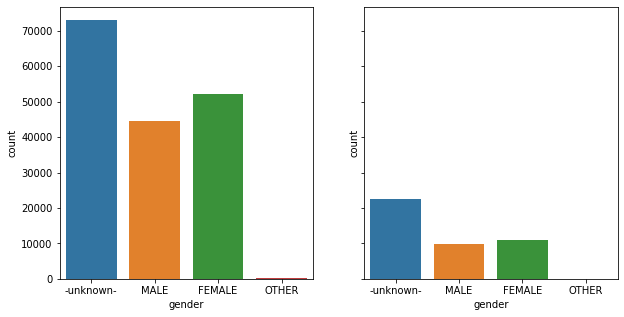

In [28]:
f, a = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
sns.countplot(x="gender", data=train, ax=a[0])
sns.countplot(x="gender", data=test, ax=a[1])

There are very few datapoints with the gender "Other". Majority of the users have gender "Unknown", maybe they preferred anonymity. Female bookings are more than male bookings in both test and train datasets.

Gender categories are not ordinal so this feature can be one hot encoded

#### Signup method

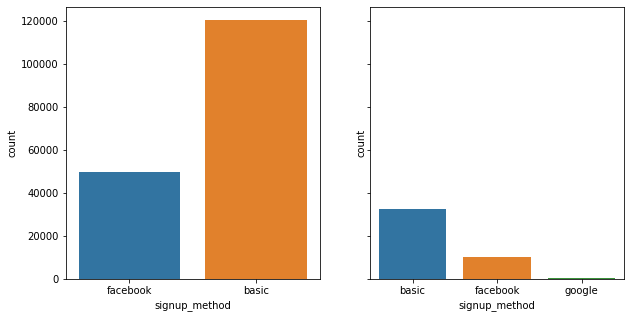

In [29]:
f, a = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
sns.countplot(x="signup_method", data=train, ax=a[0])
sns.countplot(x="signup_method", data=test, ax=a[1])

There is a new category in the test data set. This needs to be considered while encoding the categories. 

By combining train and test datasets, and then encoding them, we can capture all possible categories, then splitting back into train and test datasets
https://medium.com/@vaibhavshukla182/how-to-solve-mismatch-in-train-and-test-set-after-categorical-encoding-8320ed03552f

#### Language

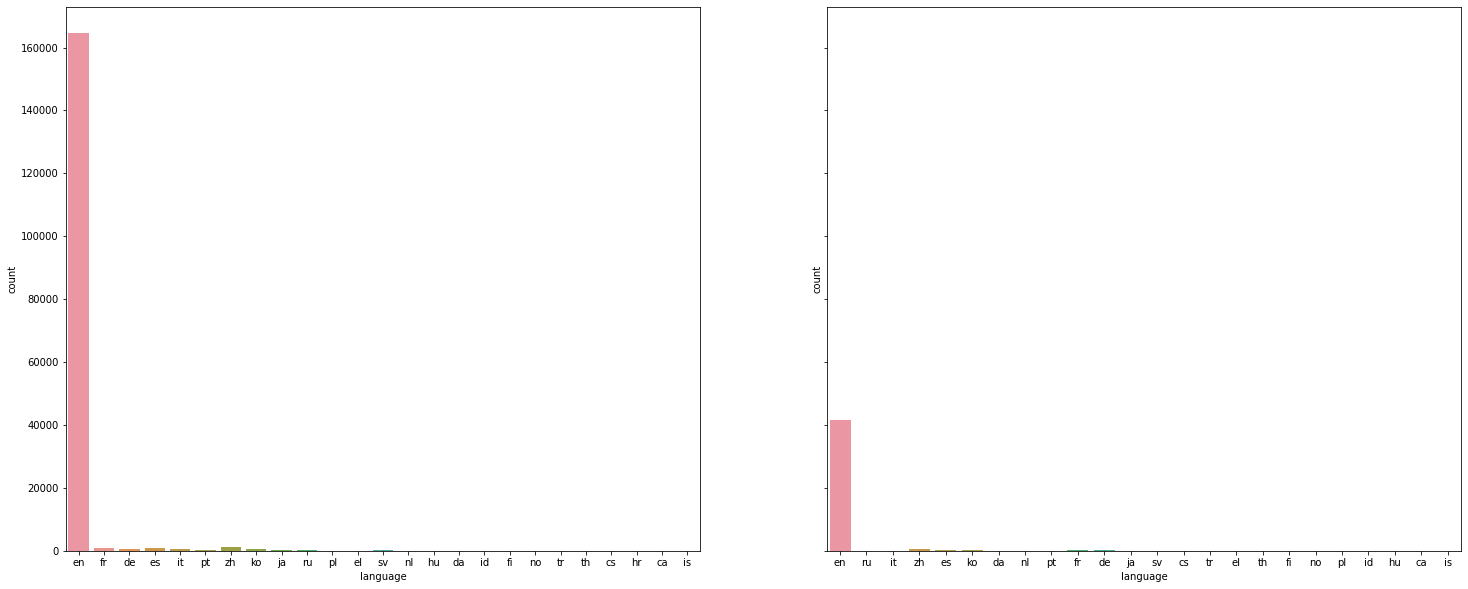

In [30]:
f, a = plt.subplots(1, 2, sharey=True, figsize=(25, 10))
sns.countplot(x="language", data=train, ax=a[0])
sns.countplot(x="language", data=test, ax=a[1])

Very small number of bookings with other languages. We can combine these categories to form a new "other" category.

#### Affiliate channel

[Text(0, 0, 'direct'),
 Text(0, 0, 'api'),
 Text(0, 0, 'sem-non-brand'),
 Text(0, 0, 'sem-brand'),
 Text(0, 0, 'seo'),
 Text(0, 0, 'content'),
 Text(0, 0, 'other'),
 Text(0, 0, 'remarketing')]

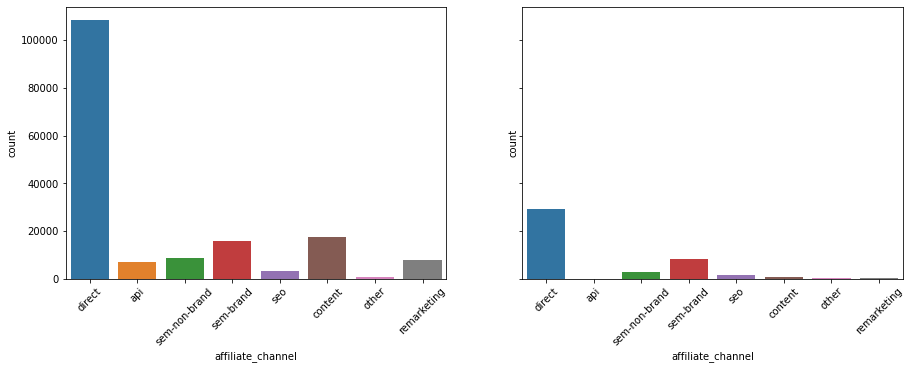

In [31]:
f, a = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 5))
p1 = sns.countplot(x="affiliate_channel", data=train, ax=a[0])
p2 = sns.countplot(x="affiliate_channel", data=test, ax=a[1])
p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

Not too many categories to be combined, and nominal categories. Can be one hot encoded

#### Affiliate provider

[Text(0, 0, 'direct'),
 Text(0, 0, 'other'),
 Text(0, 0, 'google'),
 Text(0, 0, 'facebook'),
 Text(0, 0, 'yahoo'),
 Text(0, 0, 'padmapper'),
 Text(0, 0, 'bing'),
 Text(0, 0, 'baidu'),
 Text(0, 0, 'email-marketing'),
 Text(0, 0, 'facebook-open-graph'),
 Text(0, 0, 'meetup'),
 Text(0, 0, 'naver'),
 Text(0, 0, 'craigslist'),
 Text(0, 0, 'gsp'),
 Text(0, 0, 'yandex'),
 Text(0, 0, 'daum')]

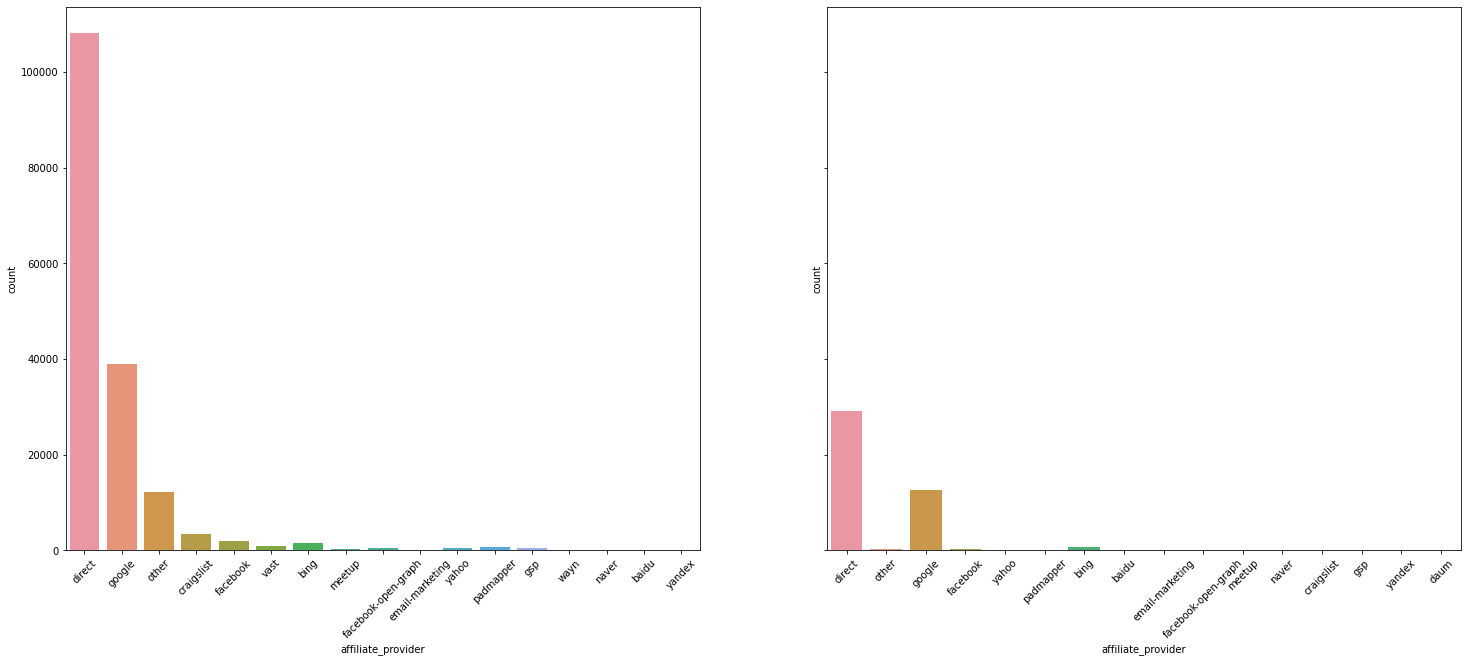

In [32]:
f, a = plt.subplots(1, 2, sharey=True, figsize=(25, 10))
p1 = sns.countplot(x="affiliate_provider", data=train, ax=a[0])
p2 = sns.countplot(x="affiliate_provider", data=test, ax=a[1])
p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

In [33]:
print("Training data affiliate_provider categories-{}".format(len(train.affiliate_provider.value_counts().index)),
      "\nTesting data affiliate_provider categories-{}".format(len(test.affiliate_provider.value_counts().index)))

Training data affiliate_provider categories-17 
Testing data affiliate_provider categories-16


In [34]:
train.affiliate_provider.value_counts()

direct                 108215
google                  39049
other                   12259
craigslist               3469
facebook                 2040
bing                     1634
vast                      829
padmapper                 699
facebook-open-graph       516
yahoo                     454
gsp                       442
meetup                    341
email-marketing           112
naver                      39
baidu                      22
yandex                      9
wayn                        8
Name: affiliate_provider, dtype: int64

In [35]:
test.affiliate_provider.value_counts()

direct                 29211
google                 12644
bing                     694
other                    290
facebook                 233
padmapper                 69
email-marketing           54
yahoo                     42
facebook-open-graph       29
naver                     13
gsp                       11
yandex                     8
baidu                      7
meetup                     6
craigslist                 2
daum                       1
Name: affiliate_provider, dtype: int64

There are few different categories in train and test datasets, similar to signup_method. Encoding must be done **after combining categories**.

There are also categories with very few datapoints, such as daum, wayn, yandex, baidu, naver. These can be combined to form a new category

#### First affiliate tracked

[Text(0, 0, 'untracked'),
 Text(0, 0, 'omg'),
 Text(0, 0, 'linked'),
 Text(0, 0, 'tracked-other'),
 Text(0, 0, 'product'),
 Text(0, 0, 'local ops'),
 Text(0, 0, 'marketing')]

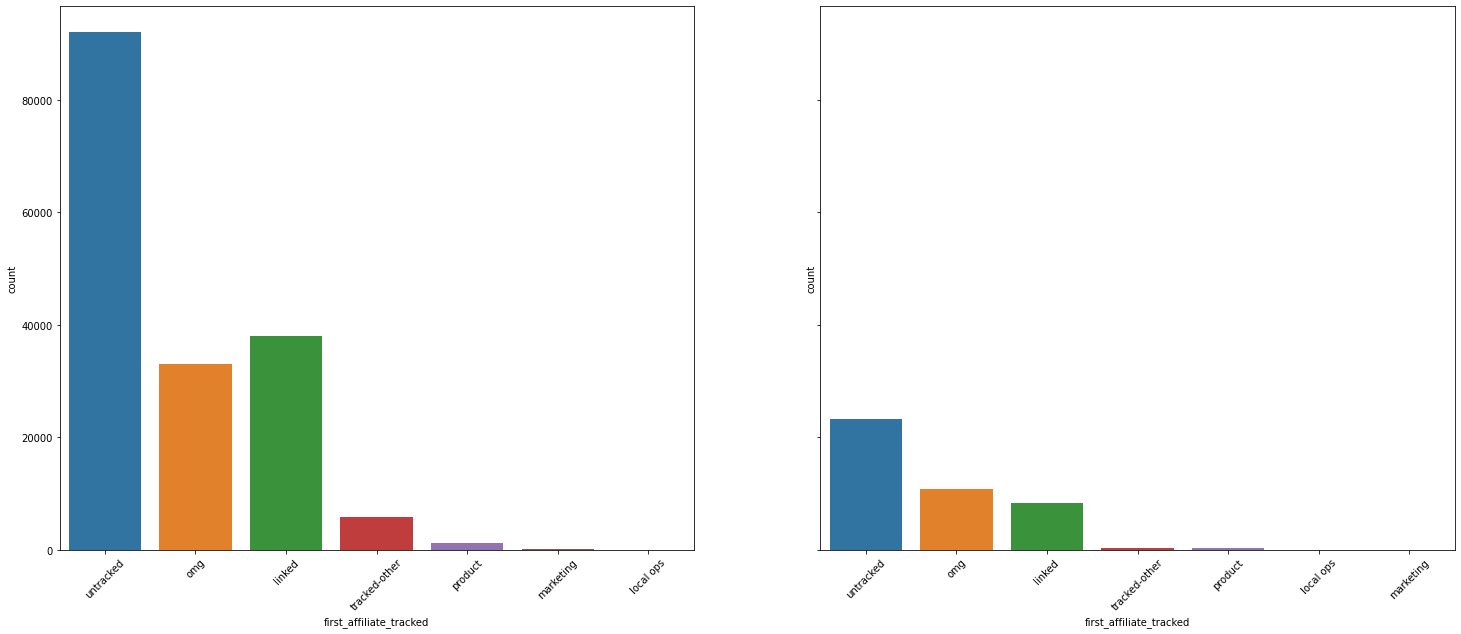

In [36]:
f, a = plt.subplots(1, 2, sharey=True, figsize=(25, 10))
p1 = sns.countplot(x="first_affiliate_tracked", data=train, ax=a[0])
p2 = sns.countplot(x="first_affiliate_tracked", data=test, ax=a[1])
p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

Majority of the first affiliates are untracked

This feature doesn't have too many categories and is nominal. Can be one hot encoded.

#### Signup app

[Text(0, 0, 'Web'),
 Text(0, 0, 'iOS'),
 Text(0, 0, 'Android'),
 Text(0, 0, 'Moweb')]

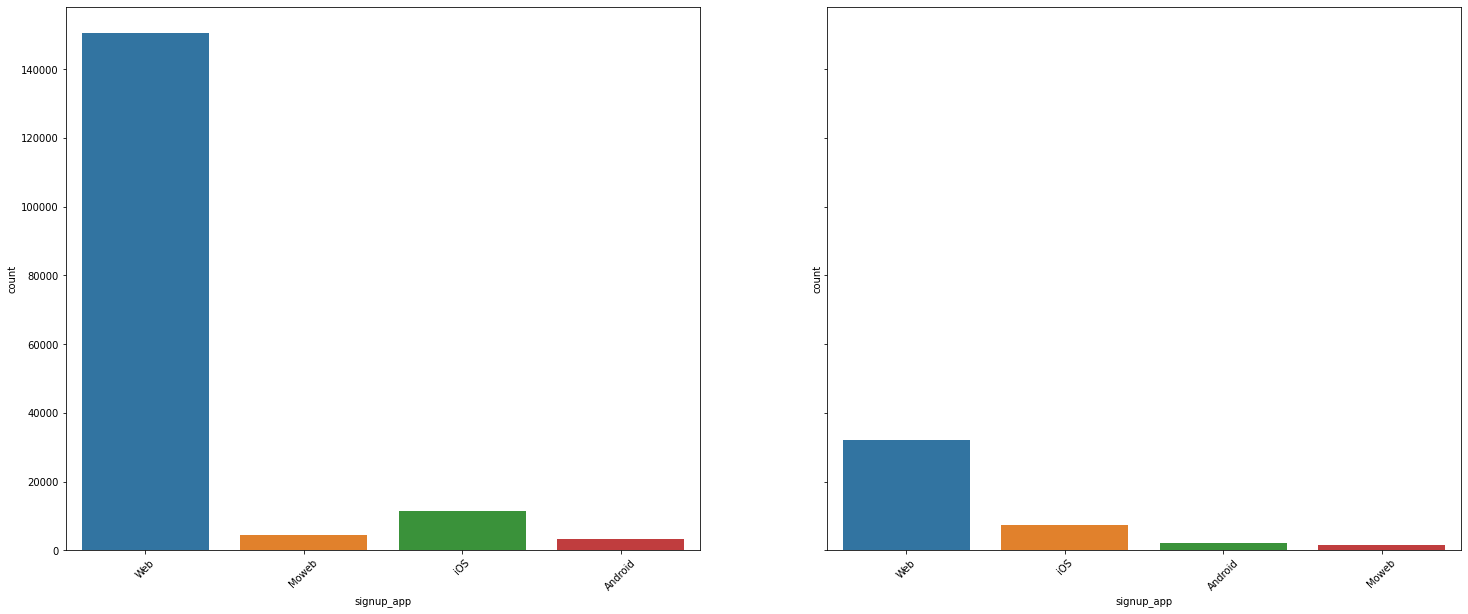

In [37]:
f, a = plt.subplots(1, 2, sharey=True, figsize=(25, 10))
p1 = sns.countplot(x="signup_app", data=train, ax=a[0])
p2 = sns.countplot(x="signup_app", data=test, ax=a[1])
p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

Web is the most popular way to signup through.

Nominal feature with 4 categories. Can be one hot encoded.

#### First device type

[Text(0, 0, 'Mac Desktop'),
 Text(0, 0, 'iPhone'),
 Text(0, 0, 'Windows Desktop'),
 Text(0, 0, 'iPad'),
 Text(0, 0, 'Other/Unknown'),
 Text(0, 0, 'Android Phone'),
 Text(0, 0, 'Android Tablet'),
 Text(0, 0, 'Desktop (Other)'),
 Text(0, 0, 'SmartPhone (Other)')]

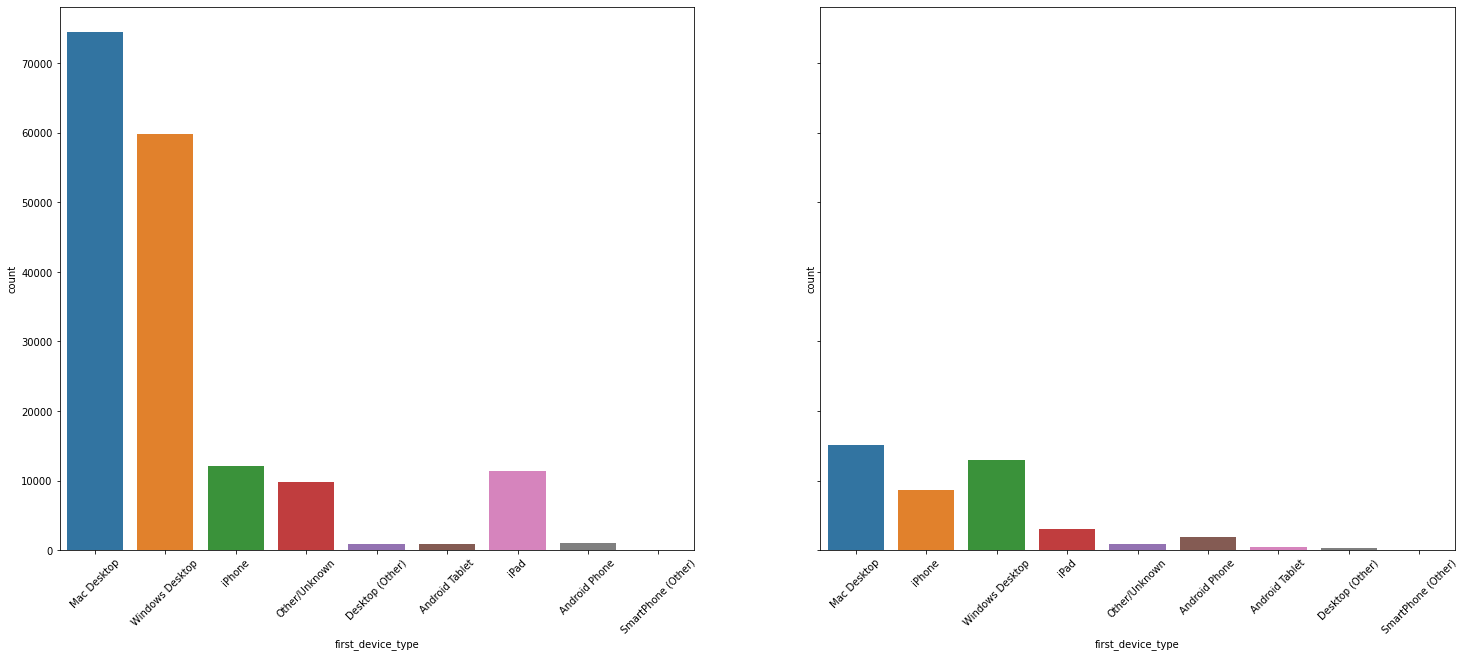

In [38]:
f, a = plt.subplots(1, 2, sharey=True, figsize=(25, 10))
p1 = sns.countplot(x="first_device_type", data=train, ax=a[0])
p2 = sns.countplot(x="first_device_type", data=test, ax=a[1])
p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

Nominal feature, can be one hot encoded.

#### First browser

[Text(0, 0, 'Safari'),
 Text(0, 0, 'Mobile Safari'),
 Text(0, 0, 'Chrome'),
 Text(0, 0, '-unknown-'),
 Text(0, 0, 'IE'),
 Text(0, 0, 'Firefox'),
 Text(0, 0, 'Chrome Mobile'),
 Text(0, 0, 'Apple Mail'),
 Text(0, 0, 'Android Browser'),
 Text(0, 0, 'Chromium'),
 Text(0, 0, 'AOL Explorer'),
 Text(0, 0, 'BlackBerry Browser'),
 Text(0, 0, 'Opera'),
 Text(0, 0, 'SiteKiosk'),
 Text(0, 0, 'IE Mobile'),
 Text(0, 0, 'Outlook 2007'),
 Text(0, 0, 'Mobile Firefox'),
 Text(0, 0, 'CoolNovo'),
 Text(0, 0, 'Silk'),
 Text(0, 0, 'Maxthon'),
 Text(0, 0, 'IceWeasel'),
 Text(0, 0, 'Iron'),
 Text(0, 0, 'Sogou Explorer'),
 Text(0, 0, 'Pale Moon'),
 Text(0, 0, 'IceDragon'),
 Text(0, 0, 'Yandex.Browser'),
 Text(0, 0, 'TheWorld Browser'),
 Text(0, 0, 'RockMelt'),
 Text(0, 0, 'Avant Browser')]

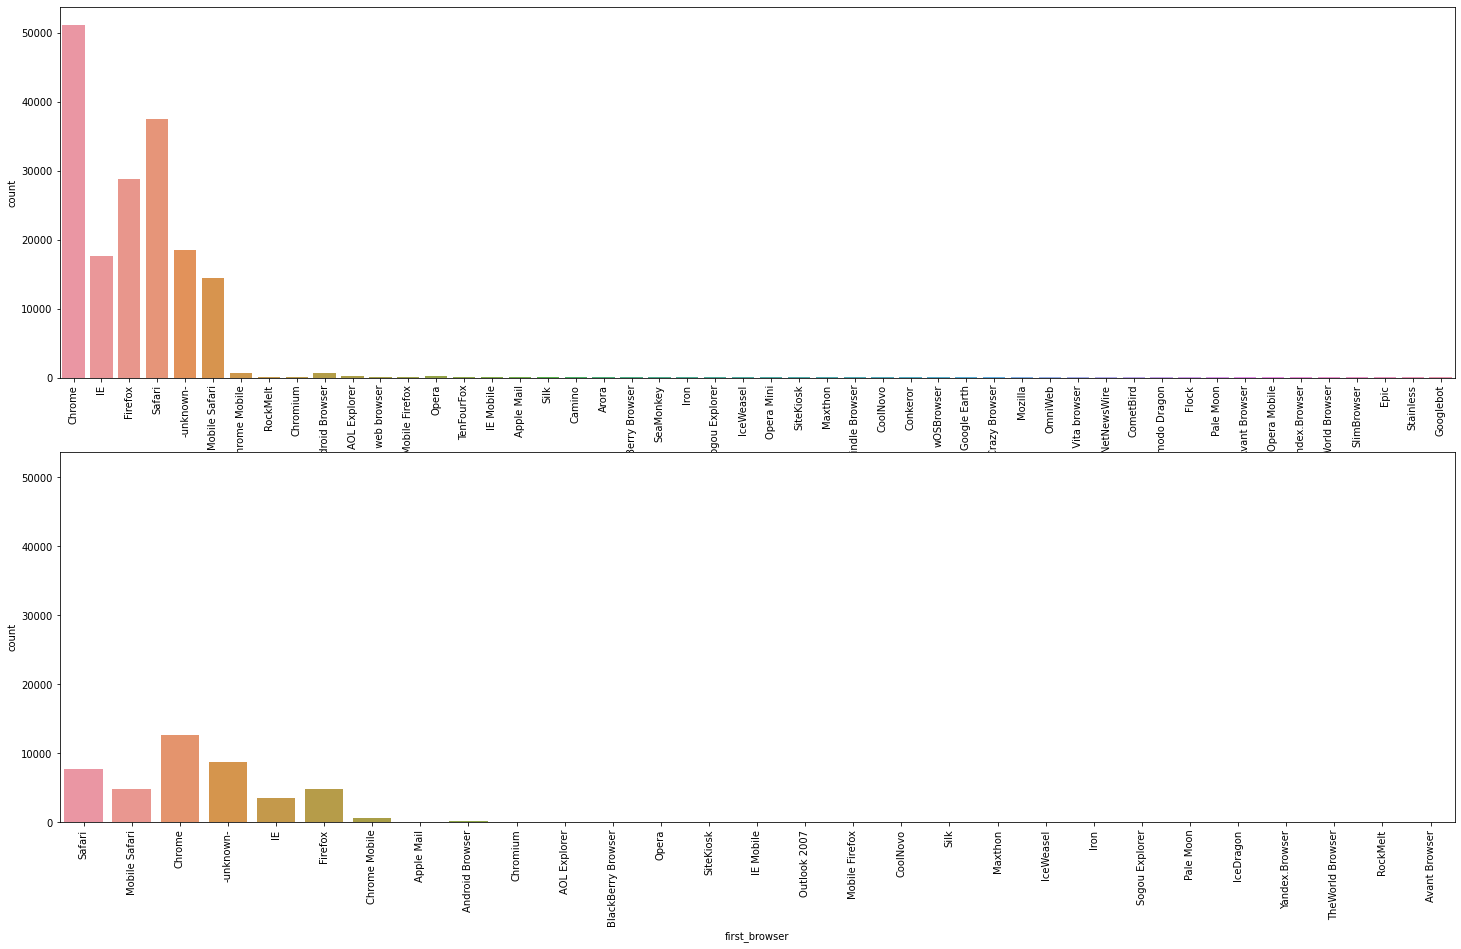

In [39]:
f, a = plt.subplots(2, 1, sharey=True, figsize=(25, 15))
p1 = sns.countplot(x="first_browser", data=train, ax=a[0])
p2 = sns.countplot(x="first_browser", data=test, ax=a[1])
p1.set_xticklabels(p1.get_xticklabels(), rotation=90)
p2.set_xticklabels(p2.get_xticklabels(), rotation=90)

Chrome is the most used web browser than others in both test and train data.

Test data has fewer browsers than train data. This can be encoded accordingly by **concatenating test and train data**.

In [40]:
train.first_browser.value_counts()

Chrome                  51191
Safari                  37464
Firefox                 28858
-unknown-               18469
IE                      17598
Mobile Safari           14393
Chrome Mobile             648
Android Browser           621
AOL Explorer              232
Opera                     162
Silk                       98
Chromium                   60
BlackBerry Browser         47
Maxthon                    39
Apple Mail                 30
Sogou Explorer             25
RockMelt                   23
SiteKiosk                  21
IE Mobile                  18
Iron                       16
Mobile Firefox             16
SeaMonkey                  11
CometBird                  11
Pale Moon                  10
Camino                      9
IceWeasel                   9
TenFourFox                  8
Yandex.Browser              7
wOSBrowser                  6
CoolNovo                    4
Opera Mini                  4
Mozilla                     3
Avant Browser               3
OmniWeb   

In [41]:
test.first_browser.value_counts()

Chrome                12654
-unknown-              8797
Safari                 7705
Mobile Safari          4881
Firefox                4797
IE                     3470
Chrome Mobile           622
Android Browser         230
Opera                    26
Silk                     26
IE Mobile                18
Mobile Firefox           14
Chromium                 13
AOL Explorer             13
Sogou Explorer            8
Maxthon                   7
BlackBerry Browser        6
Apple Mail                6
Yandex.Browser            4
IceWeasel                 4
SiteKiosk                 3
Pale Moon                 2
CoolNovo                  2
Avant Browser             1
RockMelt                  1
IceDragon                 1
TheWorld Browser          1
Iron                      1
Outlook 2007              1
Name: first_browser, dtype: int64

There are very few bookings(1-100) through some browsers like google earth, palm pre web browser, etc. We can make a new category combining all such categories.

#### Signup flow

[Text(0, 0, '0'),
 Text(0, 0, '8'),
 Text(0, 0, '12'),
 Text(0, 0, '21'),
 Text(0, 0, '23'),
 Text(0, 0, '24'),
 Text(0, 0, '25')]

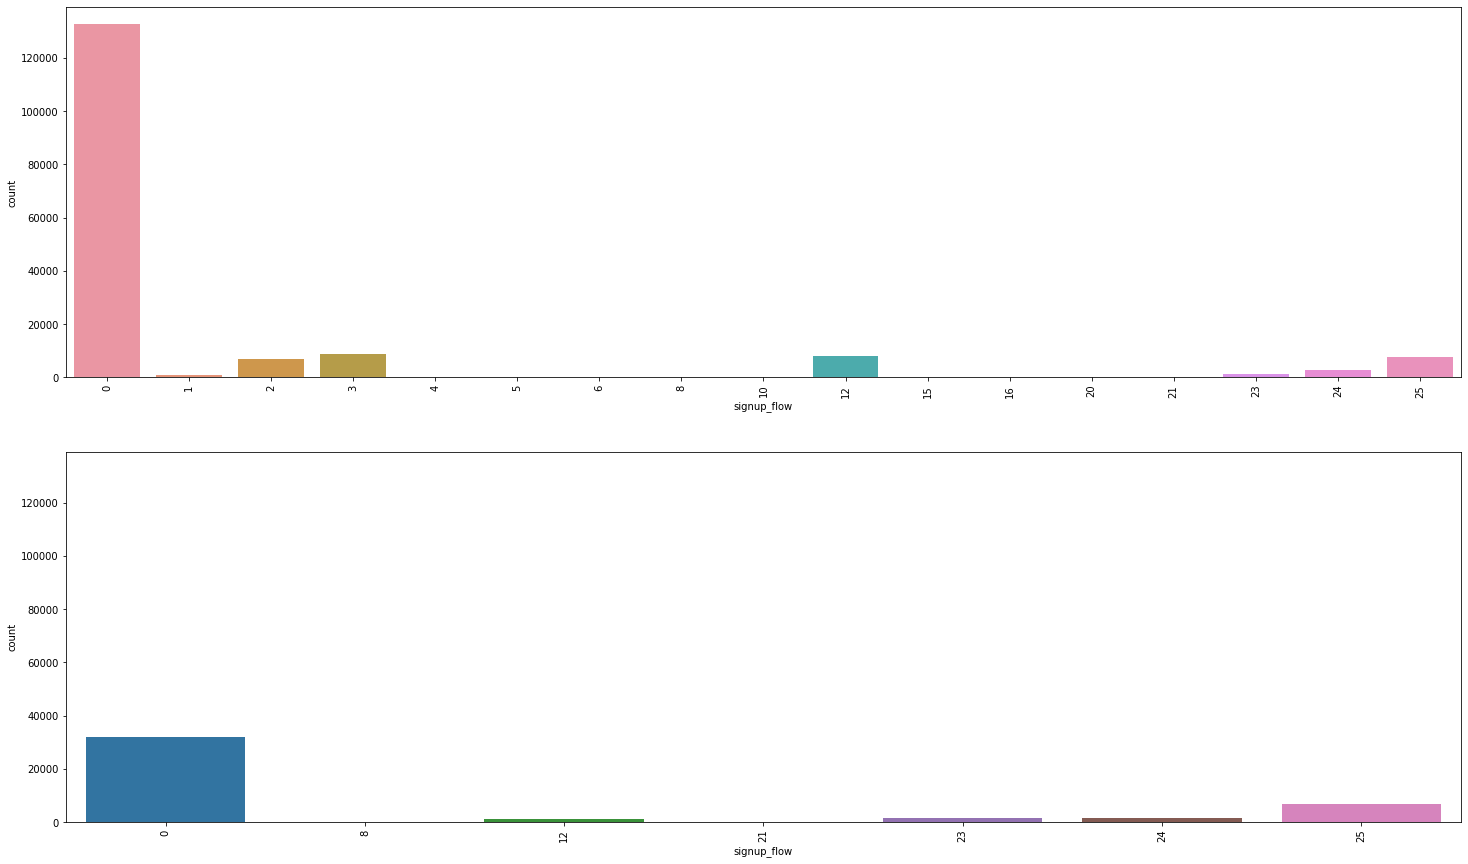

In [42]:
f, a = plt.subplots(2, 1, sharey=True, figsize=(25, 15))
p1 = sns.countplot(x="signup_flow", data=train, ax=a[0])
p2 = sns.countplot(x="signup_flow", data=test, ax=a[1])
p1.set_xticklabels(p1.get_xticklabels(), rotation=90)
p2.set_xticklabels(p2.get_xticklabels(), rotation=90)

Test data doesn't have users of all signup flows. Users of 0 signup flow are the highest by far. Maybe this is because large number of users have not choosen any country destination

#### Date account created

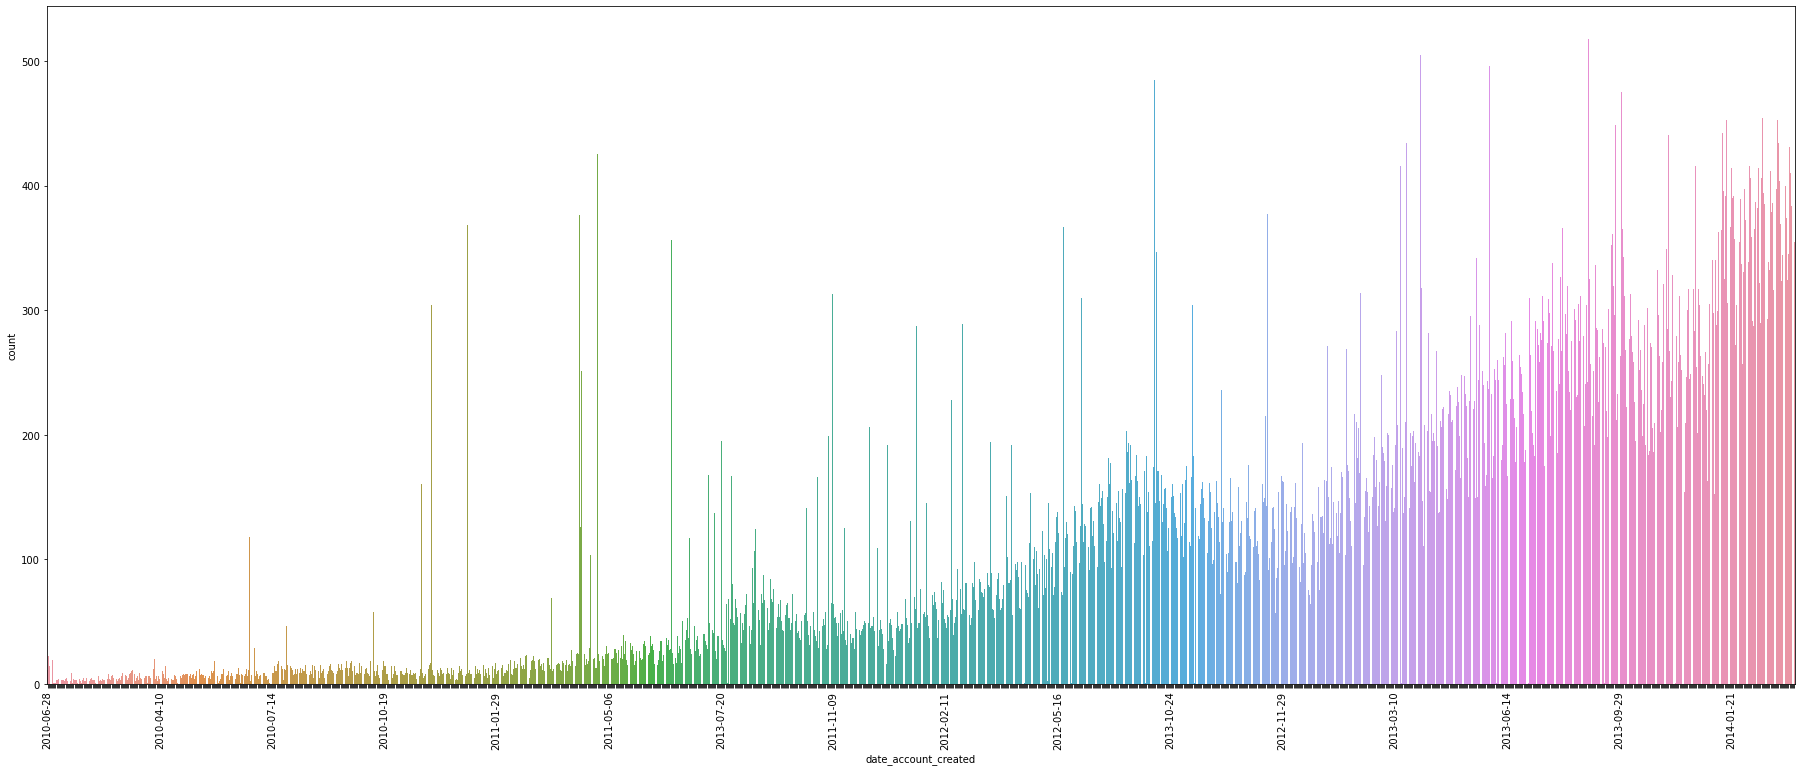

In [43]:
f, a = plt.subplots(figsize=(25, 10))
f.tight_layout()

p1 = sns.countplot(x="date_account_created", data=train)
p1.set_xticklabels(p1.get_xticklabels(), rotation=90)
for ind, label in enumerate(p1.get_xticklabels()):
    if ind % 100 == 0:  # every 100th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

There are some days where there are particularly more accounts created compared to other days around that date. Other than that, the accounts created keep increasing every year, maybe due to the increasing popularity of airbnb

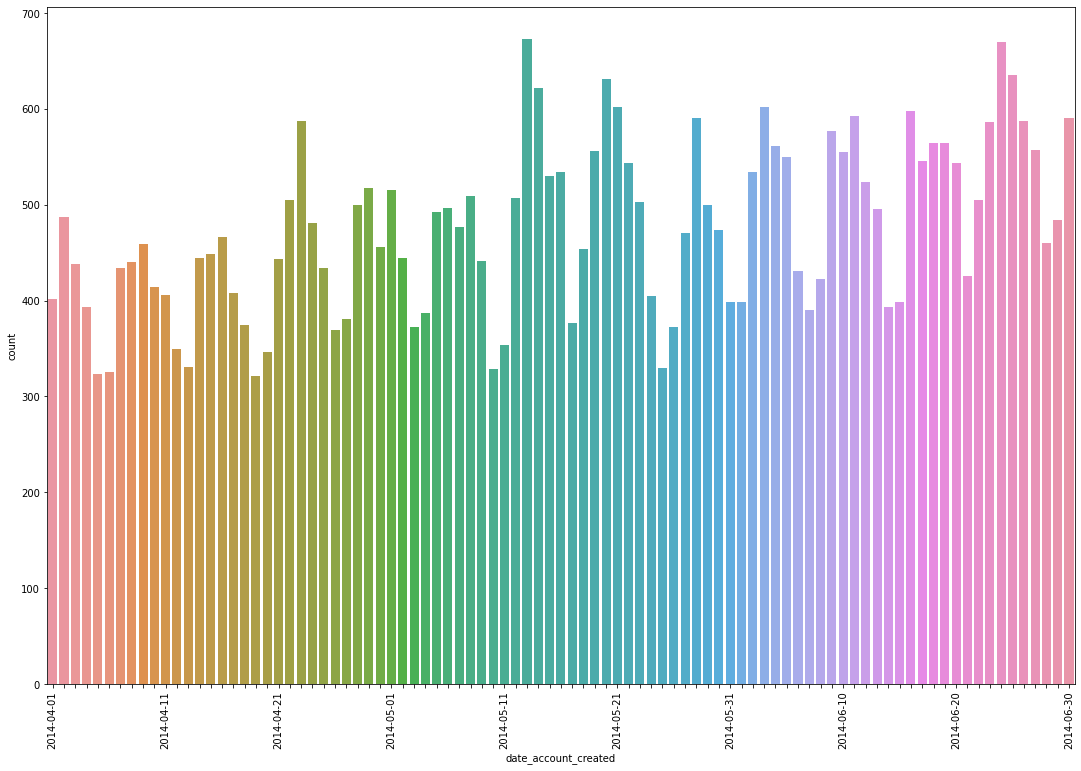

In [44]:
f, a = plt.subplots(figsize=(15, 10))
f.tight_layout()

p2 = sns.countplot(x="date_account_created", data=test)
p2.set_xticklabels(p2.get_xticklabels(), rotation=90)
for ind, label in enumerate(p2.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

The pattern above seems periodic. Maybe it has got to do with the weekdays.

Type of date_account_created is a string, so let's convert this to an analyzable type, pd.DateTime

In [45]:
train.date_account_created = pd.to_datetime(train.date_account_created)
test.date_account_created = pd.to_datetime(test.date_account_created)

We can analyze the accounts creation per month

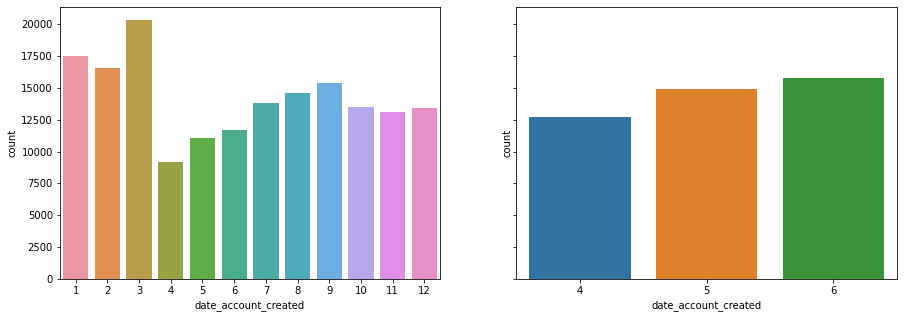

In [46]:
f, a = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

month_tr = train['date_account_created'].dt.month
month_ts = test['date_account_created'].dt.month

p1 = sns.countplot(x=month_tr, ax=a[0])
p2 = sns.countplot(x=month_ts, ax=a[1])
# p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
# p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

Accounts created are highest in the month of March. After a huge drop in April, creations steadily increase till September. this might be because of summer vacation around that time

In the test data, accounts are created only in the months of april may and july, with july being the highest. But we are not going to do anything about it because the model should be generalizable, and we've to avoid data snooping

We can extract day of the week for further analysis

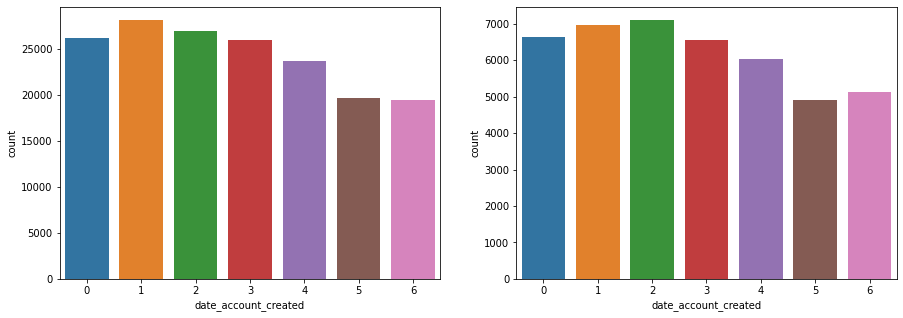

In [47]:
f, a = plt.subplots(1, 2, figsize=(15, 5))

weekday_tr = train['date_account_created'].dt.dayofweek
weekday_ts = test['date_account_created'].dt.dayofweek

p1 = sns.countplot(x=weekday_tr, ax=a[0])
p2 = sns.countplot(x=weekday_ts, ax=a[1])
# p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
# p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

Monday has highest account creations in training data and tuesday in testing data

#### Timestamp

In [48]:
train.timestamp_first_active = pd.to_datetime(train.timestamp_first_active, format="%Y%m%d%H%M%S").dt.strftime('%Y-%m-%d')
test.timestamp_first_active = pd.to_datetime(test.timestamp_first_active, format="%Y%m%d%H%M%S").dt.strftime('%Y-%m-%d')

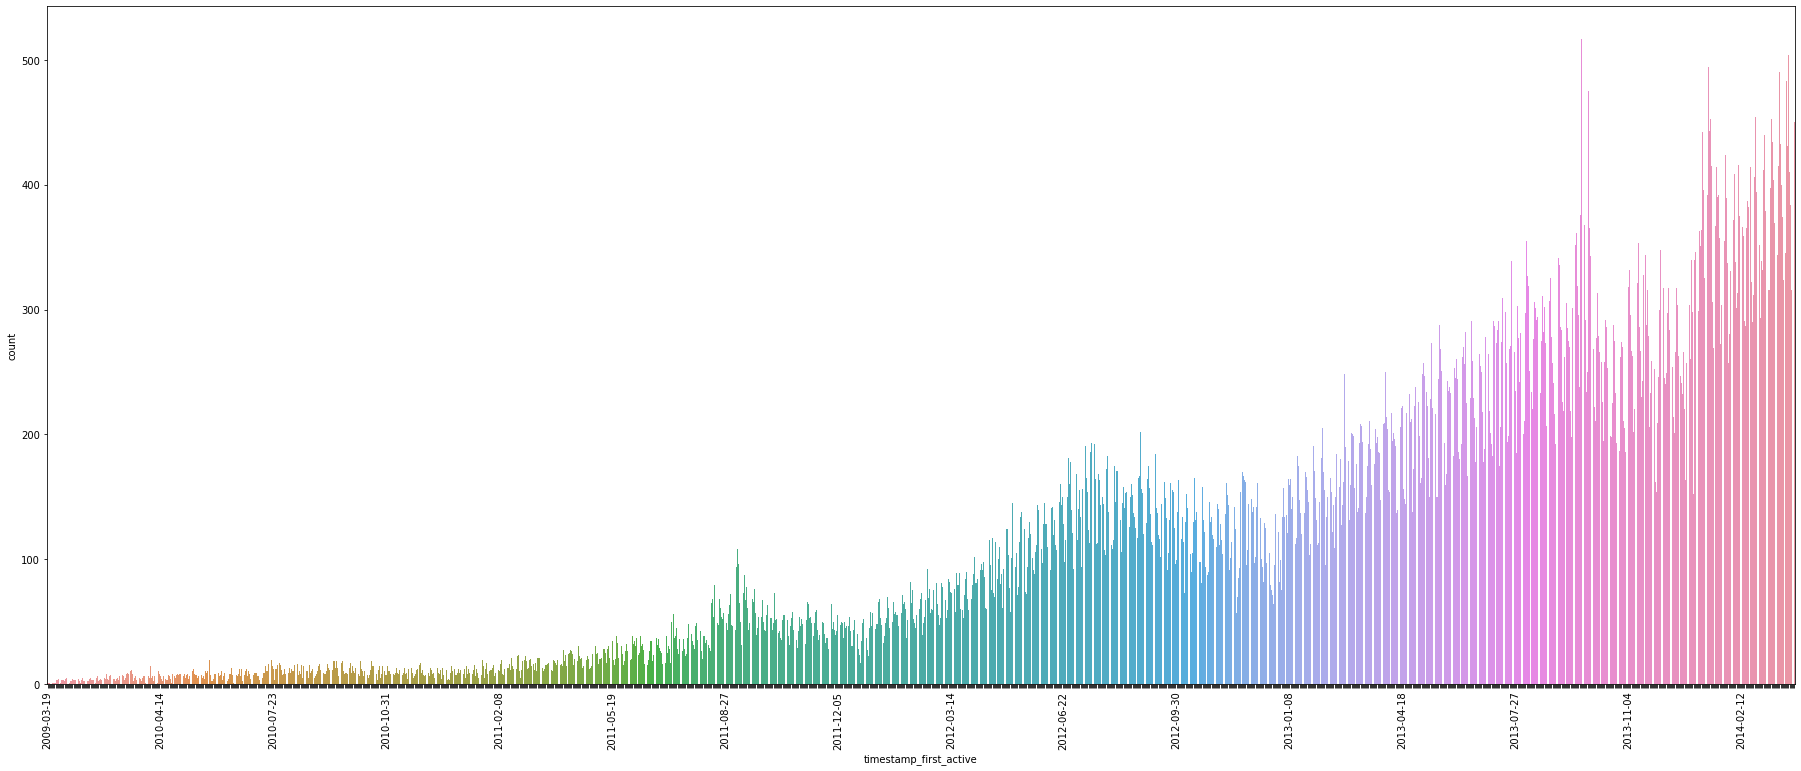

In [49]:
f, a = plt.subplots(figsize=(25, 10))
f.tight_layout()

p1 = sns.countplot(x="timestamp_first_active", data=train)
p1.set_xticklabels(p1.get_xticklabels(), rotation=90)
for ind, label in enumerate(p1.get_xticklabels()):
    if ind % 100 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)


Similar to date account crated, number of people active for the first time increase with the year. 

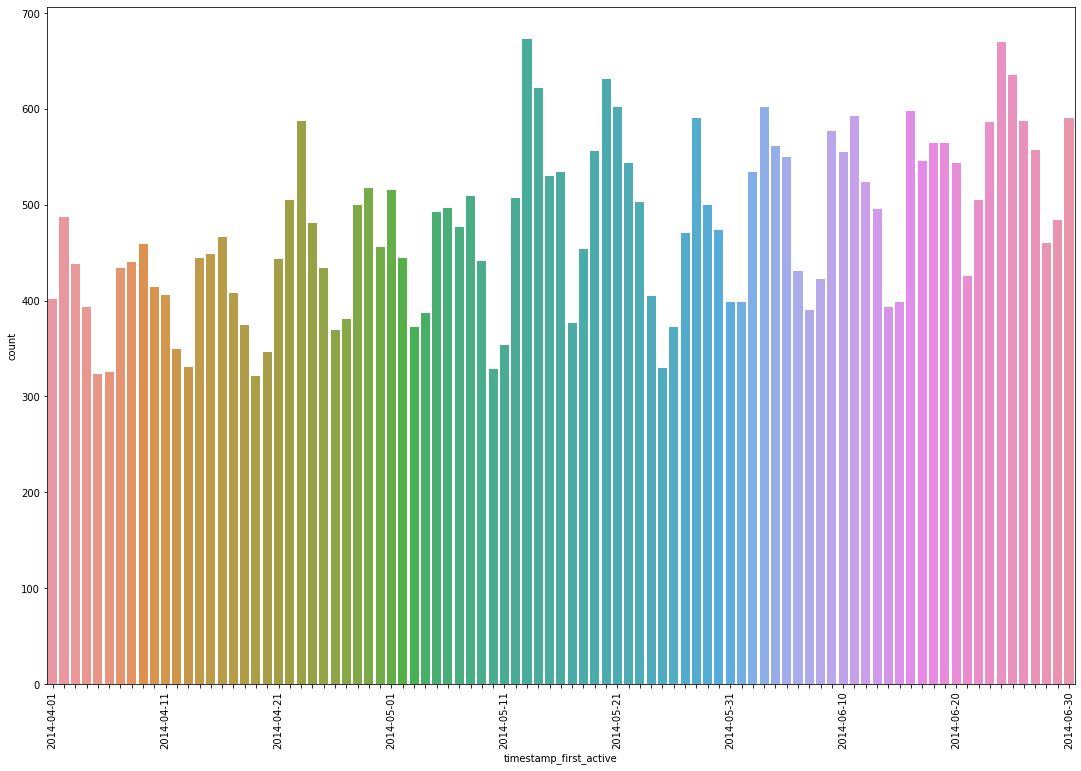

In [50]:
f, a = plt.subplots(figsize=(15, 10))
f.tight_layout()

p2 = sns.countplot(x="timestamp_first_active", data=test)
p2.set_xticklabels(p2.get_xticklabels(), rotation=90)
for ind, label in enumerate(p2.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

This also seems to have a be periodic. Let's analyse the months and day of the week for this. For this, let's convert the column back to a datetime object

In [51]:
train.timestamp_first_active = pd.to_datetime(train.timestamp_first_active)
test.timestamp_first_active = pd.to_datetime(test.timestamp_first_active)

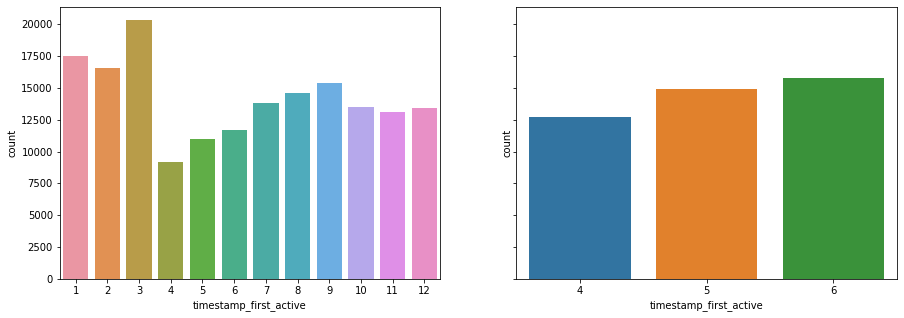

In [52]:
f, a = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

month_tr = train['timestamp_first_active'].dt.month
month_ts = test['timestamp_first_active'].dt.month

p1 = sns.countplot(x=month_tr, ax=a[0])
p2 = sns.countplot(x=month_ts, ax=a[1])
# p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
# p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

Once again the higest active users are seen in the month of March.

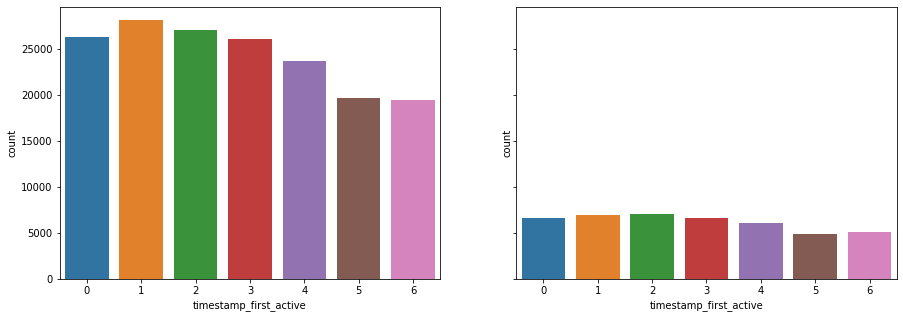

In [53]:
f, a = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

weekday_tr = train['timestamp_first_active'].dt.dayofweek
weekday_ts = test['timestamp_first_active'].dt.dayofweek

p1 = sns.countplot(x=weekday_tr, ax=a[0])
p2 = sns.countplot(x=weekday_ts, ax=a[1])
# p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
# p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

Once again, monday has the most users active for the first time in train, and tuesday in test

##### Correlation with date account created

Plots of time stamp first active and date account created seem almost similar. Let's check their correlation by converting both to number of days from 2009-01-01 as 2009 is the first year in the training data




In [54]:
(train.timestamp_first_active.sub(pd.to_datetime('2009-01-01')))/np.timedelta64(1, 'D')

0           77.0
1          142.0
2          159.0
3          303.0
4          341.0
           ...  
170132    1915.0
170133    1915.0
170134    1915.0
170135    1915.0
170136    1915.0
Name: timestamp_first_active, Length: 170137, dtype: float64

In [55]:
(train.date_account_created.sub(pd.to_datetime('2009-01-01')))/np.timedelta64(1, 'D')

0          543.0
1          874.0
2          635.0
3         1068.0
4          621.0
           ...  
170132    1915.0
170133    1915.0
170134    1915.0
170135    1915.0
170136    1915.0
Name: date_account_created, Length: 170137, dtype: float64

Gotta convert this to int by dividing by single day timedelta object

In [56]:
train_timestamp = (train.timestamp_first_active.sub(pd.to_datetime('2009-01-01')))/np.timedelta64(1, 'D') # to int as it is expressed in timedelta64 days
train_dateacc = (train.date_account_created.sub(pd.to_datetime('2009-01-01')))/np.timedelta64(1, 'D') # to int as it is expressed in timedelta64 days

In [57]:
train_timestamp.corr(train_dateacc)

0.998986548517216

That's almost 1 correlation in training data. We can drop one column. Let's drop date account created

In [58]:
train.drop("date_account_created", axis=1, inplace=True)
test.drop("date_account_created", axis=1, inplace=True)

#### Date First Booking

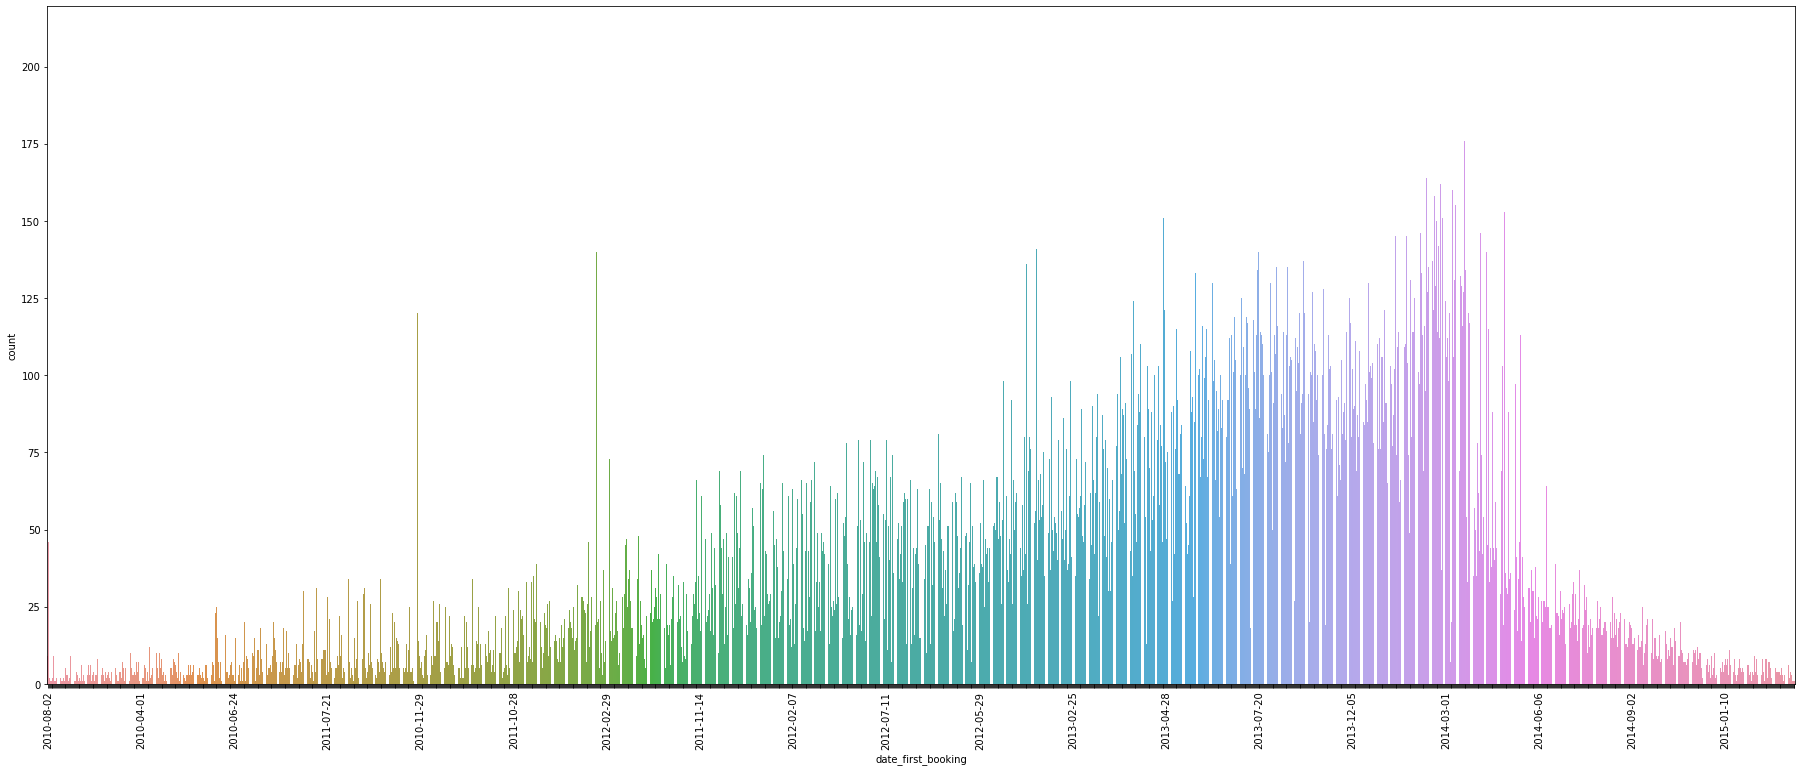

In [59]:
f, a = plt.subplots(figsize=(25, 10))
f.tight_layout()

p1 = sns.countplot(x="date_first_booking", data=train)
p1.set_xticklabels(p1.get_xticklabels(), rotation=90)
for ind, label in enumerate(p1.get_xticklabels()):
    if ind % 100 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)


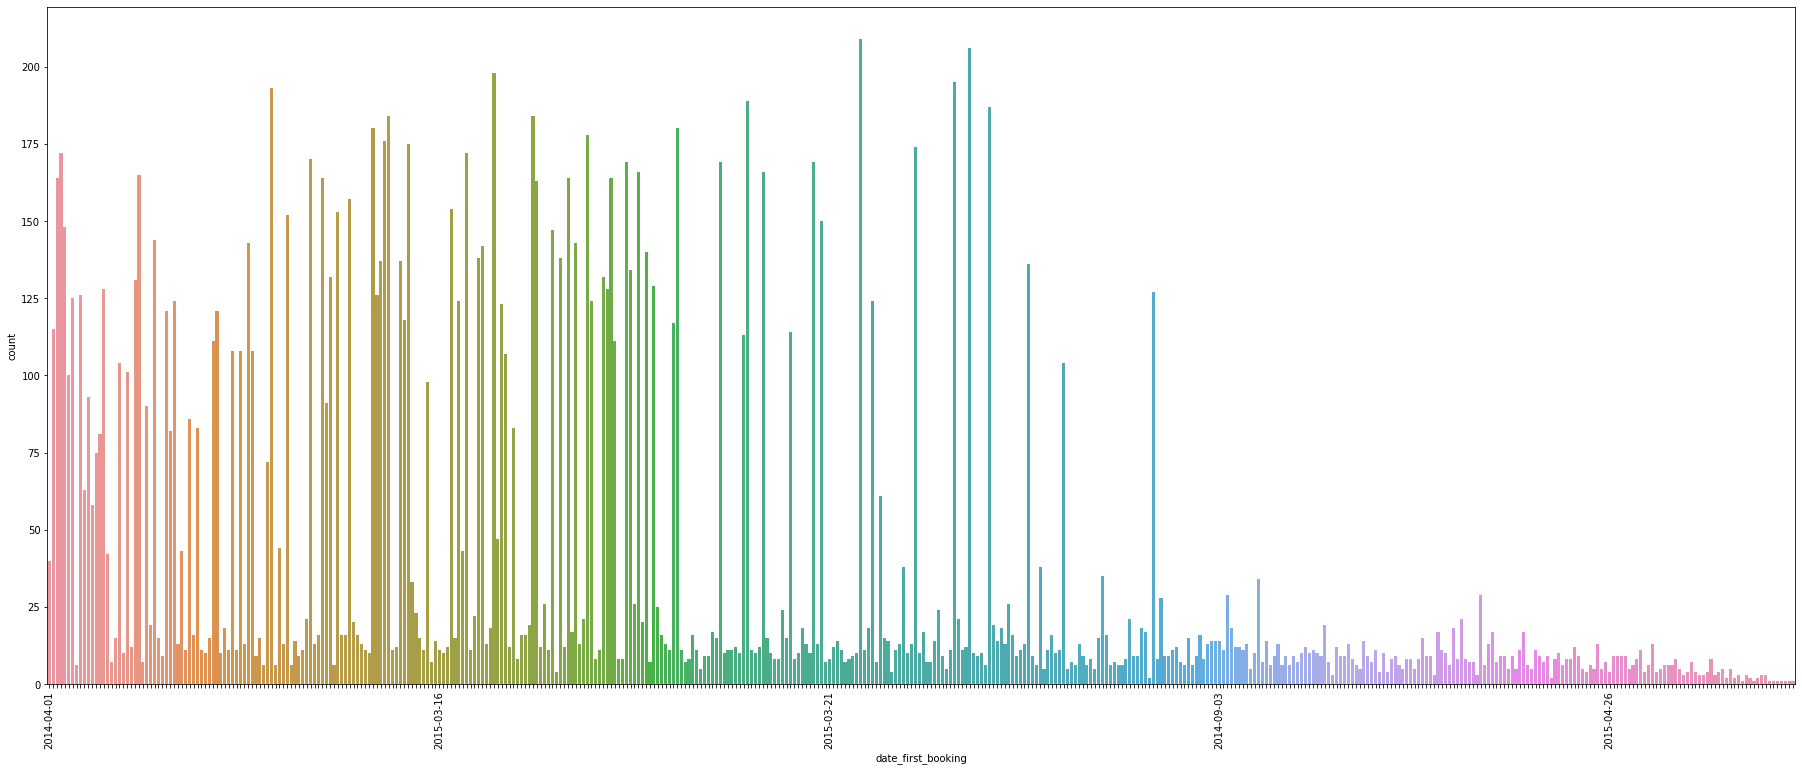

In [60]:
f, a = plt.subplots(figsize=(25, 10))
f.tight_layout()

p1 = sns.countplot(x="date_first_booking", data=test)
p1.set_xticklabels(p1.get_xticklabels(), rotation=90)
for ind, label in enumerate(p1.get_xticklabels()):
    if ind % 100 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)


Bookings seem to follow a periodical pattern again. Let's convert to datetime and look at months and days of the week

In [61]:
train.date_first_booking = pd.to_datetime(train.date_first_booking)
test.date_first_booking = pd.to_datetime(test.date_first_booking)

Year

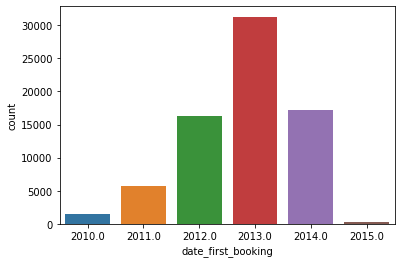

In [62]:
sns.countplot(x=train.date_first_booking.dt.year)

2013 has the highest number of bookings for airbnb

Month

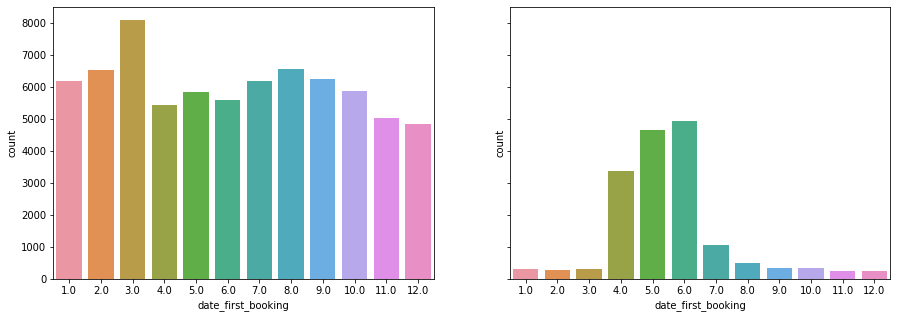

In [63]:
f, a = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

month_tr = train['date_first_booking'].dt.month
month_ts = test['date_first_booking'].dt.month

p1 = sns.countplot(x=month_tr, ax=a[0])
p2 = sns.countplot(x=month_ts, ax=a[1])
# p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
# p2.set_xticklabels(p2.get_xticklabels(), rotation=45)


Week of the day

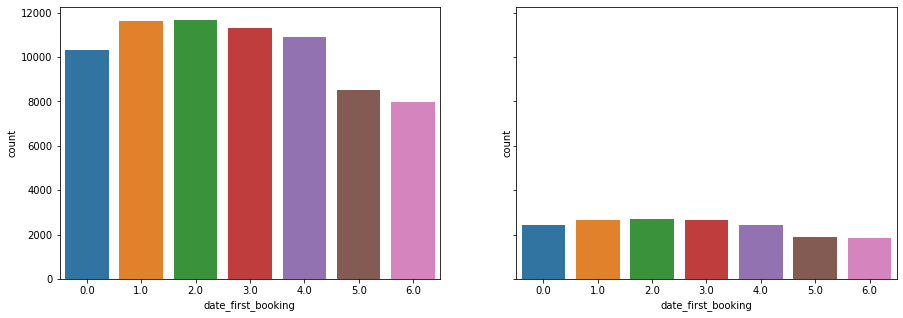

In [64]:
f, a = plt.subplots(1, 2, sharey=True, figsize=(15, 5))

weekday_tr = train['date_first_booking'].dt.dayofweek
weekday_ts = test['date_first_booking'].dt.dayofweek

p1 = sns.countplot(x=weekday_tr, ax=a[0])
p2 = sns.countplot(x=weekday_ts, ax=a[1])
# p1.set_xticklabels(p1.get_xticklabels(), rotation=45)
# p2.set_xticklabels(p2.get_xticklabels(), rotation=45)

Similar to the above features, bookings also happen more on monday-tuesdays and in the months of March-June

##### Correlation with timestamp first active

In [65]:
train_timestamp = (train.timestamp_first_active.sub(pd.to_datetime('2009-01-01')))/np.timedelta64(1, 'D') # to int as it is expressed in timedelta64 days
train_datefirst = (train.date_first_booking.sub(pd.to_datetime('2009-01-01')))/np.timedelta64(1, 'D') # to int as it is expressed in timedelta64 days

test_timestamp = (test.timestamp_first_active.sub(pd.to_datetime('2009-01-01')))/np.timedelta64(1, 'D') # to int as it is expressed in timedelta64 days
test_datefirst = (test.date_first_booking.sub(pd.to_datetime('2009-01-01')))/np.timedelta64(1, 'D') # to int as it is expressed in timedelta64 days

In [66]:
train_timestamp.corr(train_datefirst)

0.9641367568465987

That's quite high correlation of 0.96. We can drop timestamp here.

In [67]:
train.drop("timestamp_first_active", axis=1, inplace=True)
test.drop("timestamp_first_active", axis=1, inplace=True)

Day of the year

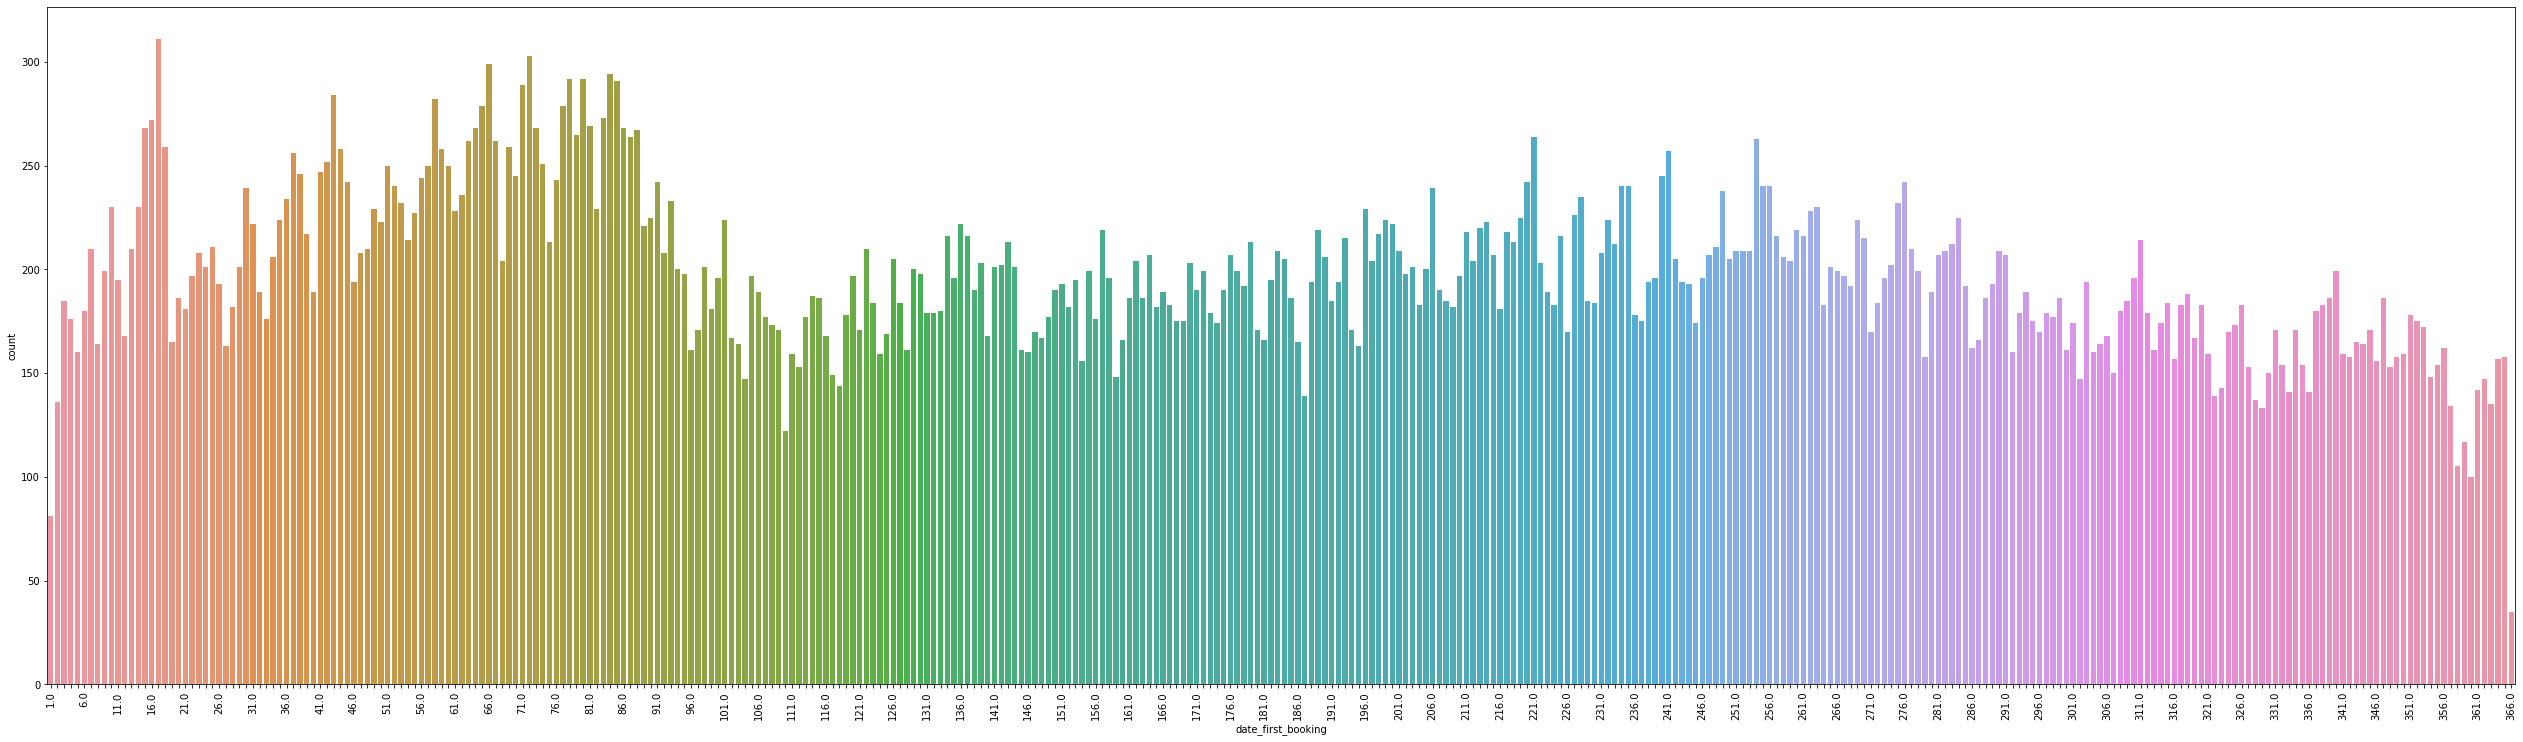

In [68]:

f, a = plt.subplots(figsize=(35, 10))
f.tight_layout()

p1 = sns.countplot(x=train.date_first_booking.dt.dayofyear)
p1.set_xticklabels(p1.get_xticklabels(), rotation=90)
for ind, label in enumerate(p1.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)


This is a combination of both the month and day of the week as we observe both the periodic nature of week days and growing bookings along the months of may-june and decrease thereafter.

#### Country Destination

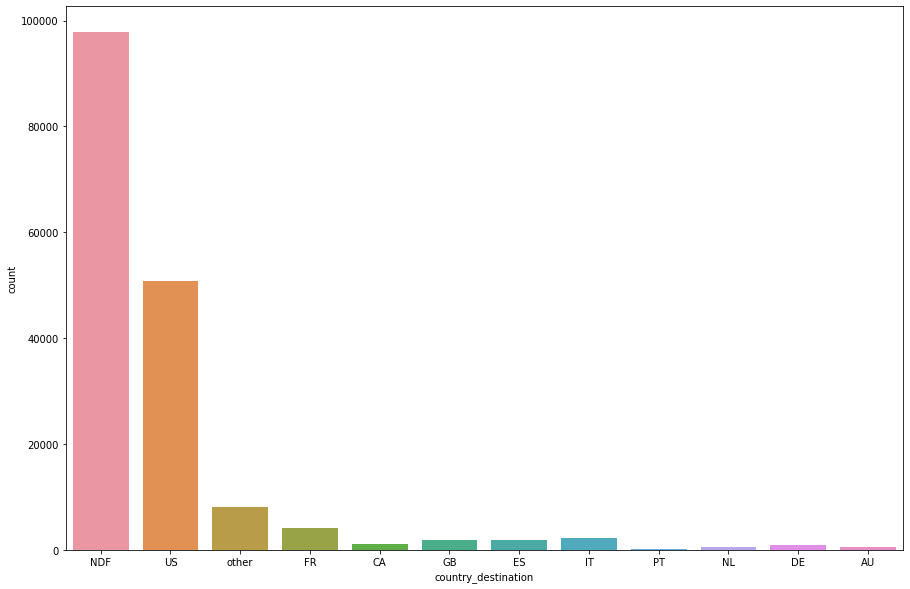

In [69]:
plt.figure(figsize=(15, 10))
sns.countplot(x=train.country_destination)

Most of the users don't book any destination, they may have just browsed and haven't actually made a booking. Other than that, next major destination is the US.

## Bivariate analysis

In [70]:
train.columns

Index(['id', 'date_first_booking', 'gender', 'age', 'signup_method',
       'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination', 'train'],
      dtype='object')

### Country Destination and features analysis

Seeing how each feature affects input destination

#### Gender vs Country Destination
Let's see if gender has any say over country destination

In [71]:
ndf_us = train[(train.country_destination == "NDF") | (train.country_destination == "US")]
rest = train[(train.country_destination != "NDF") & (train.country_destination != "US")]

#### For NDF and US

In [72]:
fig = px.parallel_categories(ndf_us, dimensions=["gender", "country_destination"])
fig.show()

Unknown gender mostly prefer NDF over other countries. Difference between NDF and US is much lesser for males and females compared to unknown gender. Meaning, **provided gender, the user is more likely to actually book a destination**. Hence, it is better to keep the category unknown as it gives us this information.

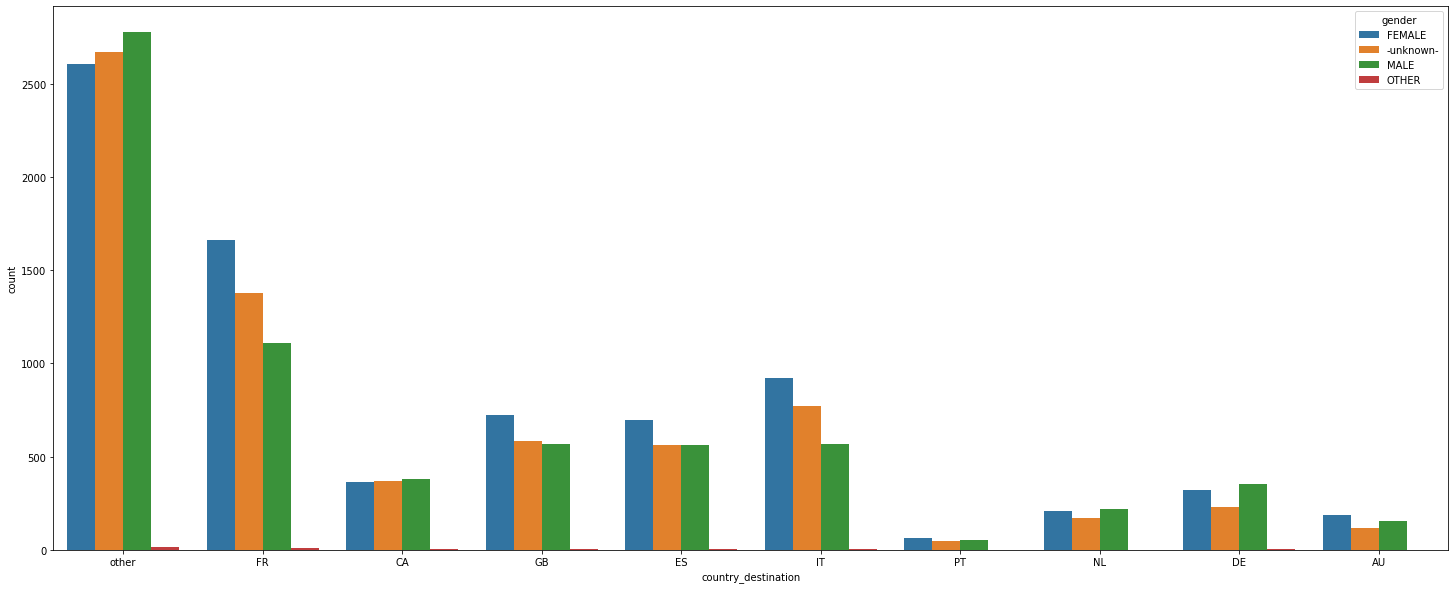

In [73]:
plt.figure(figsize=(25, 10))
sns.countplot(x="country_destination", hue="gender", data=rest)

In most of the countries(except other), female bookings are more than men or unknown.

#### Age and country destination

In [74]:
train.groupby(["country_destination"]).age.describe()

count       mean        std  ...   50%    75%    max
country_destination                                 ...                    
AU                     461.0  37.798265  13.010050  ...  34.0  40.00  110.0
CA                    1124.0  37.191281  11.535299  ...  34.0  39.25  105.0
DE                     906.0  36.693157  12.244683  ...  34.0  40.00  105.0
ES                    1824.0  35.828947  11.625124  ...  34.0  38.00  105.0
FR                    4163.0  37.424694  11.859898  ...  34.0  40.00  110.0
GB                    1881.0  38.165869  12.982563  ...  34.0  42.00  110.0
IT                    2268.0  37.521164  13.068784  ...  34.0  39.00  110.0
NDF                  97807.0  36.350302   9.961244  ...  34.0  37.00  115.0
NL                     601.0  36.637271  12.542921  ...  34.0  38.00  105.0
PT                     163.0  36.877301  11.546349  ...  34.0  38.50  105.0
US                   50864.0  36.539360  11.927326  ...  34.0  38.00  115.0
other                 8075.0  36.893994  12.269612  ...  34.0  38.00  110.0

[12 rows x 8 columns]

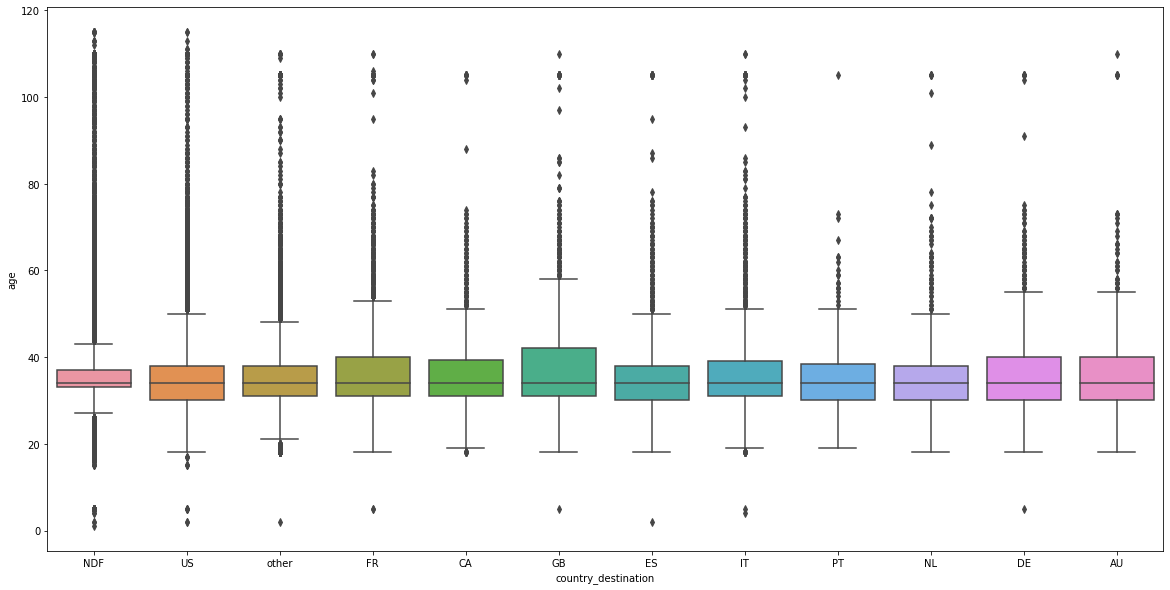

In [75]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="country_destination", y="age", data=train)

GB quantile is more on the older side, so GB has more older travellers

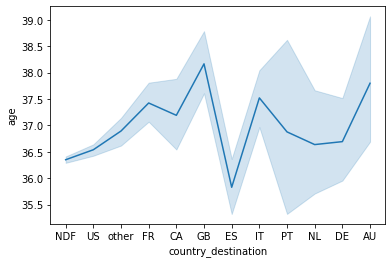

In [76]:
sns.lineplot(x="country_destination", y="age", data=train)

Spain has the youngest travelling users on average, and Great Britain the oldest on avg. 

#### Date first booking

In [77]:
train['date_first_year'] = train['date_first_booking'].dt.year

In [78]:
ndf = train[(train.country_destination == "NDF")]
us = train[(train.country_destination == "US")]
rest = train[(train.country_destination != "NDF") & (train.country_destination != "US")]

We know that all the date_first_booking values in the ndf are null

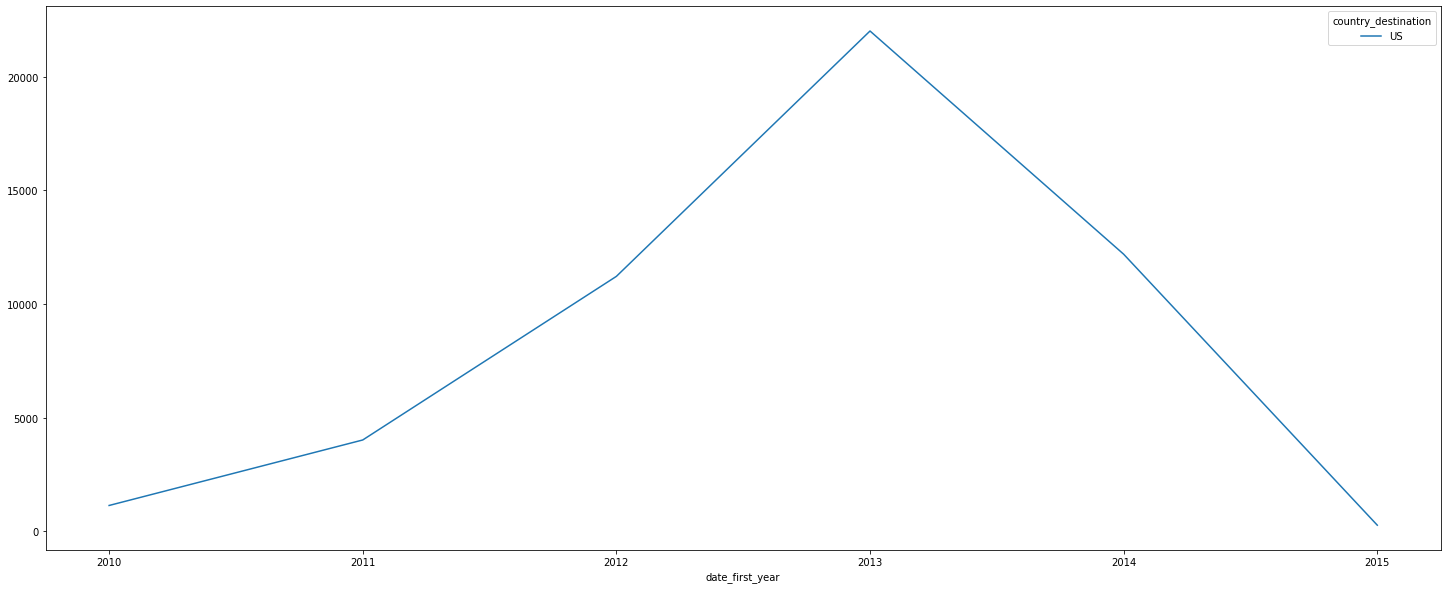

In [79]:
(us
 .groupby(['date_first_year', 'country_destination'])
 .size()
 .unstack()
 .plot(figsize=(25, 10))
)


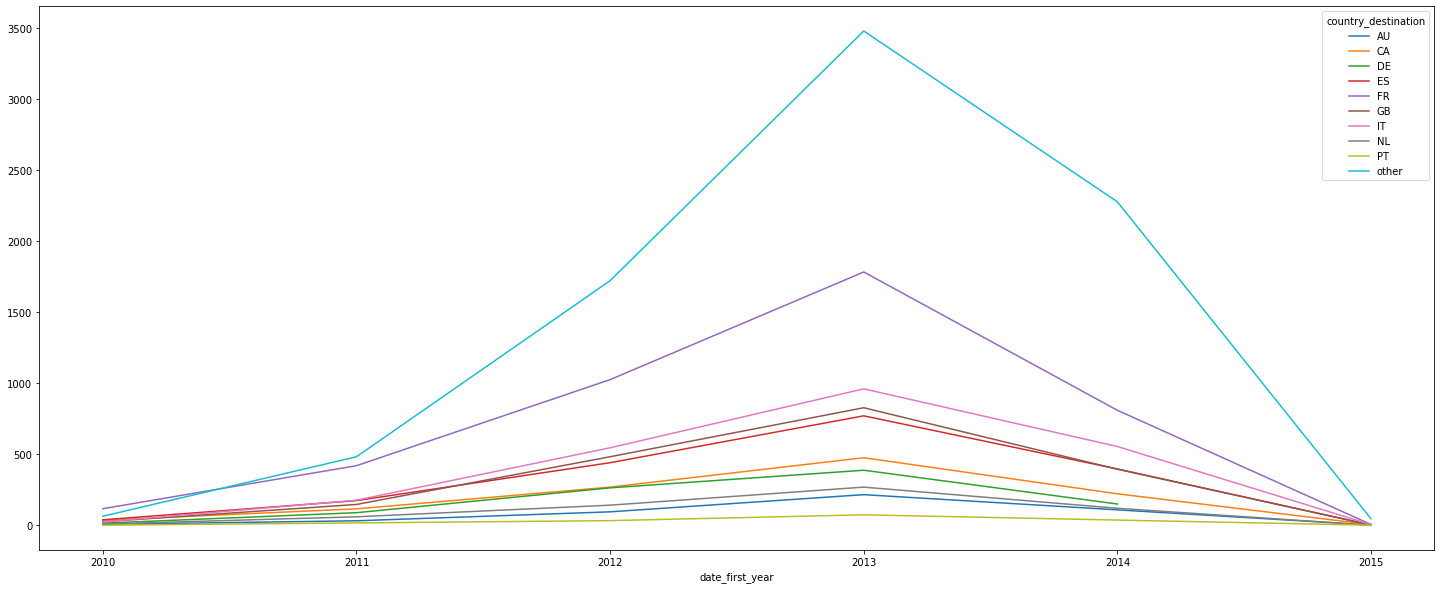

In [80]:
(rest
 .groupby(['date_first_year', 'country_destination'])
 .size()
 .unstack()
 .plot(figsize=(25, 10))
)

There is a common trend that against years, bookings increase till 2013 and decrease. But, year doesn't affect which country destination is chosen. Hence year from this feature can be dropped

In [81]:
train.drop(['date_first_year'], axis=1, inplace=True)

In [82]:
train['day_first_booking'] = train.date_first_booking.dt.dayofyear

In [83]:
test['day_first_booking'] = test.date_first_booking.dt.dayofyear

Mode of day of booking in a year vs country destination 

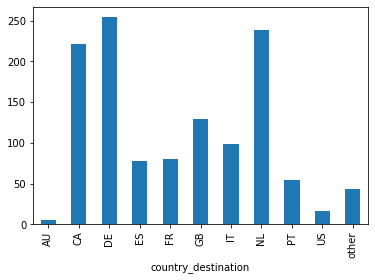

In [84]:
train[train.country_destination != "NDF"].groupby(["country_destination"]).day_first_booking.agg(lambda x: pd.Series.mode(x).iat[0]).plot.bar()

It seems better to use day of the year as the highest bookings for each country occur at different days in the year. The australian booking day might be lower coz it's summer at that time

#### Language

In [85]:
# Converting the 2 level group into 1 level of rows and 1 level of columns
lang_ctr = train.groupby(["country_destination", "language"]).count().reset_index().pivot('country_destination', 'language').train.fillna(0)

In [86]:
lang_ctr

language              ca    cs    da     de  ...    sv    th    tr     zh
country_destination                          ...                         
AU                   0.0   0.0   0.0    3.0  ...   0.0   0.0   0.0    1.0
CA                   0.0   0.0   0.0    0.0  ...   0.0   0.0   0.0    1.0
DE                   0.0   0.0   0.0   21.0  ...   0.0   0.0   0.0    1.0
ES                   0.0   1.0   2.0    6.0  ...   2.0   0.0   0.0    2.0
FR                   0.0   0.0   0.0    9.0  ...   0.0   0.0   1.0    8.0
GB                   0.0   0.0   0.0    5.0  ...   0.0   0.0   0.0    5.0
IT                   0.0   0.0   1.0    4.0  ...   0.0   0.0   1.0    4.0
NDF                  1.0  17.0  29.0  387.0  ...  58.0  17.0  35.0  794.0
NL                   0.0   0.0   0.0    2.0  ...   2.0   0.0   0.0    0.0
PT                   0.0   0.0   0.0    1.0  ...   0.0   0.0   0.0    0.0
US                   2.0   5.0  14.0  170.0  ...  31.0   2.0  13.0  298.0
other                0.0   2.0   2.0   16.0  ...   4.0   0.0   3.0   52.0

[12 rows x 25 columns]

English has way too high count, so lets plot english and the rest separately. We can drop NDF too for analysis 

In [87]:
ctrs = lang_ctr.drop('NDF')
eng_lang = ctrs[['en']]
other_lang = ctrs.drop("en", axis=1)

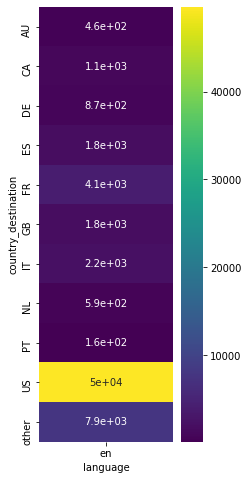

In [88]:
# from sklearn.preprocessing import StandardScaler
# lang_scaler = StandardScaler()
# eng_lang = lang_scaler.fit_transform(eng_lang)
plt.figure(figsize=(3, 8))
sns.heatmap(eng_lang, cmap="viridis", annot=True)

US has a lot of bookings, so let's view that country separately

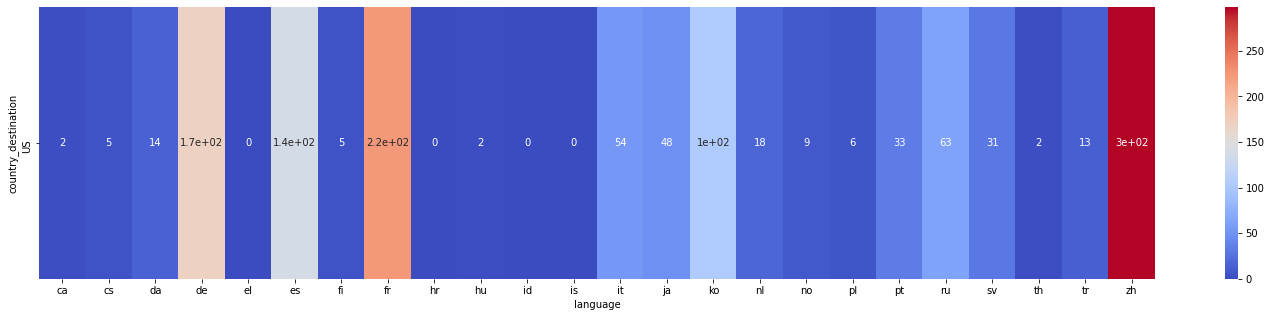

In [89]:
us_langs = other_lang.loc[['US'], :]
plt.figure(figsize=(25, 5))
sns.heatmap(us_langs, cmap="coolwarm", annot=True)

There are a lot of chinese bookings in the US

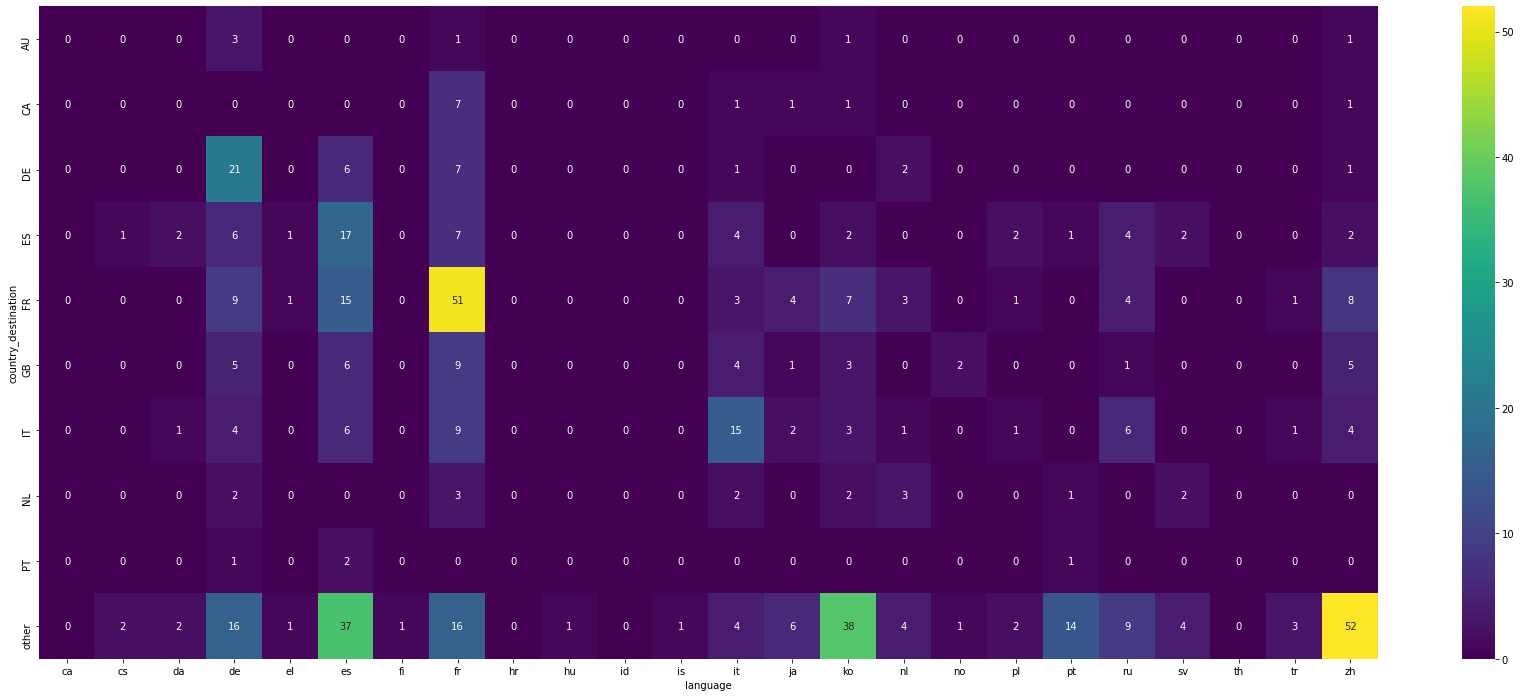

In [90]:
plt.figure(figsize=(30, 12))
sns.heatmap(other_lang.drop('US'), cmap="viridis", vmin=0, annot=True)

Language definitely helps is determining the country as seen from the above graph. 
* German language people book the most in Germany
* French language people book the most in France
* Italian language people book the most in Italy
* Spanish language people book the most in Spain, France and other countries(presumably Spanish as the official language)
* Korean language people book the most in other country(presumably Korea as it isn't in the list)
* Chinese language people book the most in other(presumably China as it isn't in the list)

# Pre Processing

ID can be dropped in both Test and Train categories

In [91]:
test_copy = test.copy()
train_copy = train.copy()
train.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)

### Categorical Columns

In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170137 entries, 0 to 170136
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date_first_booking       72330 non-null   datetime64[ns]
 1   gender                   170137 non-null  object        
 2   age                      170137 non-null  float64       
 3   signup_method            170137 non-null  object        
 4   signup_flow              170137 non-null  int64         
 5   language                 170137 non-null  object        
 6   affiliate_channel        170137 non-null  object        
 7   affiliate_provider       170137 non-null  object        
 8   first_affiliate_tracked  170137 non-null  object        
 9   signup_app               170137 non-null  object        
 10  first_device_type        170137 non-null  object        
 11  first_browser            170137 non-null  object        
 12  country_destinat

Before one hot encoding the nominal categorical features, combine train and test data to identify all the categories of features mentioned above, which have too many categories for one hot encoding, i.e., language, affiliate provider, first browser

##### Language

In [93]:
tot = pd.concat([train, test], axis=0)

In [94]:
tot.language.value_counts()

en    206314
zh      1632
fr      1172
es       915
ko       747
de       732
it       514
ru       389
pt       240
ja       225
sv       122
nl        97
tr        64
da        58
pl        54
cs        32
no        30
el        24
th        24
id        22
hu        18
fi        14
ca         5
is         5
hr         2
Name: language, dtype: int64

In [95]:
train.country_destination.unique()

array(['NDF', 'US', 'other', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL',
       'DE', 'AU'], dtype=object)

We can group some of the languages into one where the language is European, and is not primarily spoken in any of the destination countries i.e., it is in other. This group has languages

* hr is Croatian
* ca is Catalan(Andorra's language)
* is is Iceland
* fi is Finnish
* hu is Hungarian
* el is Greek
* no is Norwegian
* cs is Czech
* pl is Polish
* da is Danish


So, the categories are now 15

In [96]:
eu_langs = ['hr', 'ca', 'is', 'fi', 'hu', 'el', 'no', 'cs', 'pl', 'da']
train.language = train.language.apply(lambda x: 'eur' if x in eu_langs else x)
test.language = test.language.apply(lambda x: 'eur' if x in eu_langs else x)

In [97]:
train.language.value_counts()

en     164597
zh       1166
fr        957
es        742
de        624
ko        479
it        449
ru        312
pt        194
eur       192
ja        156
sv         97
nl         80
tr         53
id         20
th         19
Name: language, dtype: int64

In [98]:
tot = pd.concat([train, test], axis=0)

##### First Browser

In [99]:
tot.first_browser.value_counts().index.tolist()[10:]

['Silk',
 'Chromium',
 'BlackBerry Browser',
 'Maxthon',
 'Apple Mail',
 'IE Mobile',
 'Sogou Explorer',
 'Mobile Firefox',
 'RockMelt',
 'SiteKiosk',
 'Iron',
 'IceWeasel',
 'Pale Moon',
 'Yandex.Browser',
 'SeaMonkey',
 'CometBird',
 'Camino',
 'TenFourFox',
 'wOSBrowser',
 'CoolNovo',
 'Opera Mini',
 'Avant Browser',
 'Mozilla',
 'TheWorld Browser',
 'Crazy Browser',
 'SlimBrowser',
 'Comodo Dragon',
 'Opera Mobile',
 'OmniWeb',
 'Flock',
 'Epic',
 'PS Vita browser',
 'Kindle Browser',
 'Stainless',
 'Outlook 2007',
 'NetNewsWire',
 'Google Earth',
 'Conkeror',
 'Palm Pre web browser',
 'Googlebot',
 'IceDragon',
 'Arora']

In [100]:
# Converting the 2 level group into 1 level of rows and 1 level of columns
brows = tot.groupby(["first_browser", "language"]).count().reset_index().pivot('language', 'first_browser').train.fillna(0)

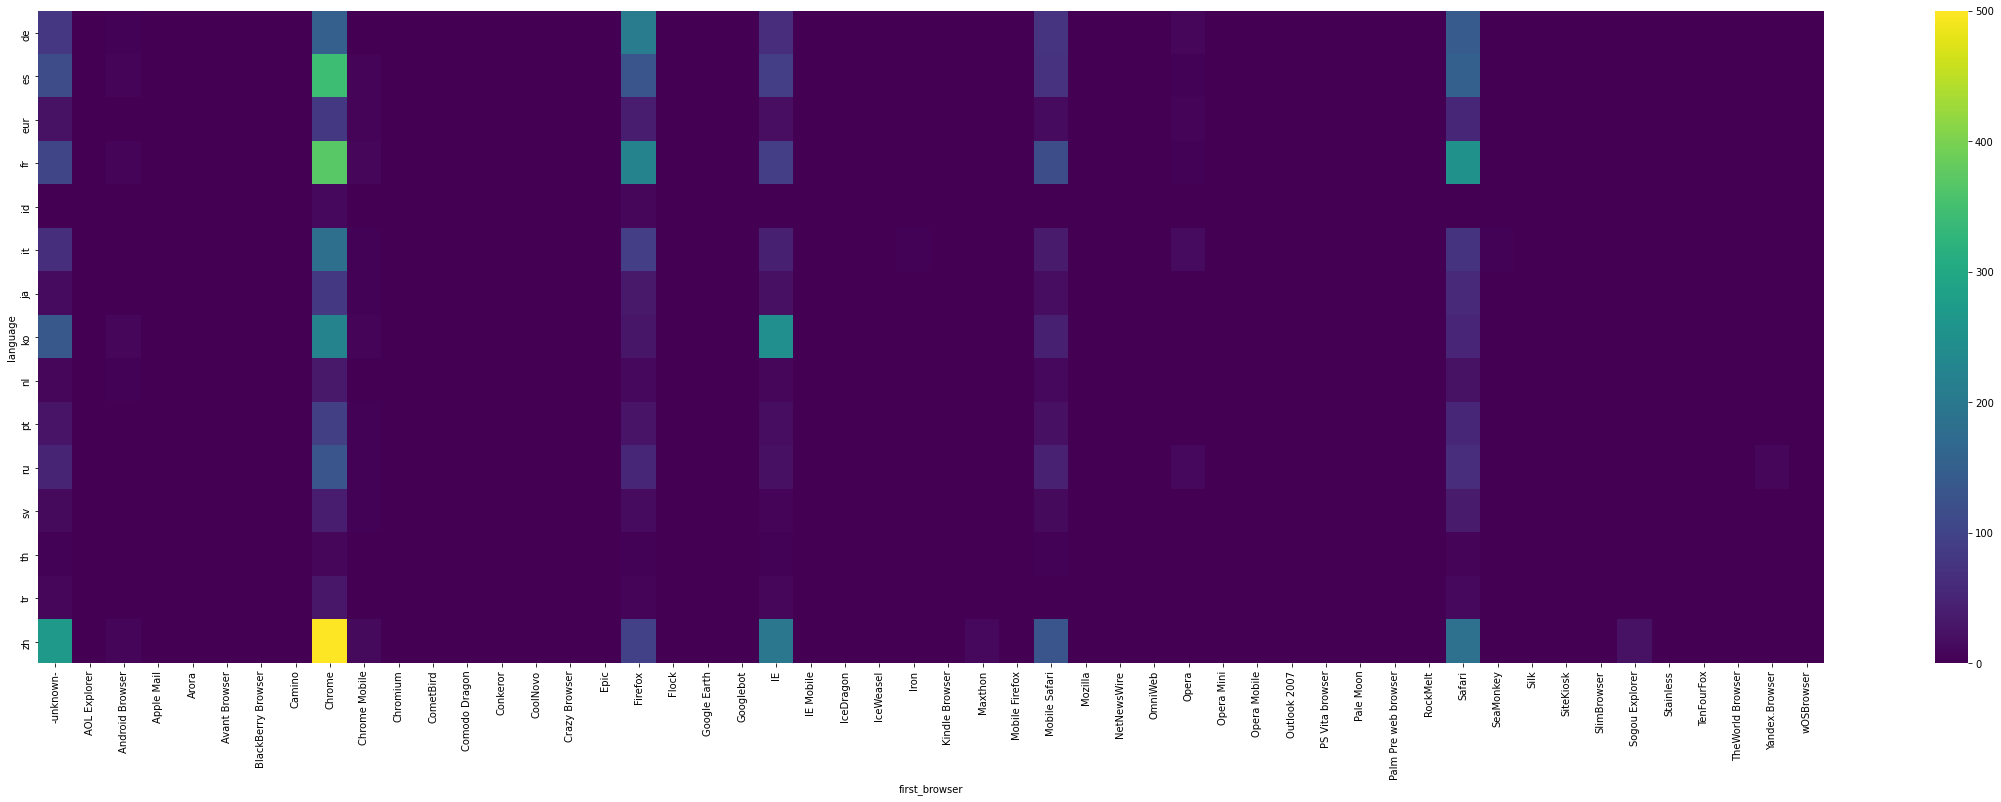

In [101]:
plt.figure(figsize=(40, 12))
sns.heatmap(brows.drop('en'), cmap="viridis", vmin=0, vmax=500)

There is no way of deciding browser through language. So just group the least count values

In [102]:
least_brows = tot.first_browser.value_counts().index.tolist()[10:]
train.first_browser = train.first_browser.apply(lambda x: 'other_browsers' if x in least_brows else x)
test.first_browser = test.first_browser.apply(lambda x: 'other_browsers' if x in least_brows else x)

##### First affiliate

In [103]:
tot.affiliate_provider.value_counts()

direct                 137426
google                  51693
other                   12549
craigslist               3471
bing                     2328
facebook                 2273
vast                      829
padmapper                 768
facebook-open-graph       545
yahoo                     496
gsp                       453
meetup                    347
email-marketing           166
naver                      52
baidu                      29
yandex                     17
wayn                        8
daum                        1
Name: affiliate_provider, dtype: int64

In [104]:
least_aff_prov = tot.affiliate_provider.value_counts().index.tolist()[-5:]
train.affiliate_provider = train.affiliate_provider.apply(lambda x: 'combined' if x in least_aff_prov else x)
test.affiliate_provider = test.affiliate_provider.apply(lambda x: 'combined' if x in least_aff_prov else x)

##### Reflect to total 

In [105]:
tot = pd.concat([train, test], axis=0)

##### Dropping NDF 

In [106]:
ndf_rows = tot[tot.country_destination == "NDF"]
tot_country = tot.dropna(subset=['date_first_booking'])

In [292]:
test_total = tot.copy()

In [107]:
tot_country.country_destination.value_counts()

US       50864
other     8075
FR        4163
IT        2268
GB        1881
ES        1824
CA        1124
DE         906
NL         601
AU         461
PT         163
Name: country_destination, dtype: int64

In [108]:
Y_train_test = tot_country[["country_destination", "train"]]
Y_train = Y_train_test[Y_train_test.train == 1].drop("train", axis=1)
print(Y_train)

       country_destination
2                       US
3                    other
4                       US
5                       US
6                       US
...                    ...
170118                  US
170122                  US
170125                  US
170128                  US
170134                  CA

[72330 rows x 1 columns]


In [109]:
tot_country.drop("country_destination", axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No NDF values are present


##### One hot features

In [110]:
otypes=tot_country.dtypes[tot_country.dtypes=="object"].index
print(otypes)

Index(['gender', 'signup_method', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser'],
      dtype='object')


In [111]:
dummy = pd.get_dummies(tot_country[otypes], drop_first=True)
total = pd.concat([tot_country.drop(otypes, axis=1), dummy], axis=1)

In [293]:
dummy_test = pd.get_dummies(test_total[otypes], drop_first=True)
test_total = pd.concat([test_total.drop(otypes, axis=1), dummy_test], axis=1)

In [112]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88908 entries, 2 to 43308
Data columns (total 71 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   date_first_booking                      88908 non-null  datetime64[ns]
 1   age                                     88908 non-null  float64       
 2   signup_flow                             88908 non-null  int64         
 3   train                                   88908 non-null  int64         
 4   day_first_booking                       88908 non-null  float64       
 5   gender_FEMALE                           88908 non-null  uint8         
 6   gender_MALE                             88908 non-null  uint8         
 7   gender_OTHER                            88908 non-null  uint8         
 8   signup_method_facebook                  88908 non-null  uint8         
 9   signup_method_google                    88908 non-

date_first_booking is being represented through day_first_booking as days from 0-366. So, we can drop date_first_booking. Year cannot be used in the model as we want the model to predict for future years as well

In [113]:
total.drop("date_first_booking", axis=1, inplace=True)

In [294]:
test_total.drop("date_first_booking", axis=1, inplace=True)

Todo cyclic encoding


Test train separation

In [114]:
X_train = total[total.train == 1]
X_test = total[total.train == 0]

In [115]:
X_train.drop("train", axis=1, inplace=True)
X_test.drop("train", axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [116]:
total.train

2        1
3        1
4        1
5        1
6        1
        ..
43278    0
43302    0
43304    0
43306    0
43308    0
Name: train, Length: 88908, dtype: int64

In [117]:
from sklearn.preprocessing import StandardScaler
scaler_tr = StandardScaler()
scaler_ts = StandardScaler()
X_train = scaler_tr.fit_transform(X_train)
X_test = scaler_ts.fit_transform(X_test)

In [118]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(Y_train.country_destination.ravel())

In [119]:
def get_top_countries(proba, n):
  top_idx = np.flip(np.argsort(ypr_prob)[:, -n:])
  return np.apply_along_axis(le.inverse_transform, 1, top_idx)

In [120]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
k_fold = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
sorted(sklearn.metrics.SCORERS.keys())

In [121]:
!pip install parfit


  Created wheel for parfit: filename=parfit-0.220-cp36-none-any.whl size=8661 sha256=86d83f26c24ec9717efde6405e5ecd85c450486b8bbf38bcec1219b1c2ba55f9
  Stored in directory: /root/.cache/pip/wheels/d9/8a/c9/ed86e85ad0cb41ce2fdcb6bc215902dc475bd3fb1fef7c742d
Successfully built parfit


## Choosing Model

In [201]:
from sklearn.model_selection import train_test_split
xtr, xvl, ytr, yvl = train_test_split(X_train, y, stratify=y, random_state = 420)

### Bayes

In [ ]:
clf = BernoulliNB()
print(cross_val_score(clf, X_train, y, cv=k_fold, n_jobs=-1, scoring="roc_auc_ovr"))

[0.54850797 0.54675982 0.54876348 0.54102637 0.54508564 0.55597893
 0.54576967 0.55884352 0.57631546 0.55775939]


### Logreg

In [277]:
from sklearn.linear_model import LogisticRegression

In [278]:
clf = LogisticRegression(class_weight={})


In [279]:
clf.fit(X_train, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [283]:
clf.predict_proba(X_test)[0]

array([8.52720456e-04, 1.47827235e-02, 3.27199918e-04, 1.58845160e-02,
       3.84606898e-03, 7.44564097e-03, 2.78357141e-03, 2.14298310e-03,
       4.26159382e-05, 9.29335562e-01, 2.25563972e-02])

### XGB

In [213]:
from sklearn.metrics import ndcg_score

def get_true_y(row, col, y_labels):
  indexed_y = np.ndarray(shape=(row, col))
  for i, val in enumerate(y_labels):
    indexed_y[i][val] = 1
  return indexed_y

def my_ndcg_score(ytrue, ypred, k=3):
  return ndcg_score(ypred, get_true_y(ytrue.shape[0], ypred.shape[1], ytrue), k)

In [202]:
from xgboost import XGBClassifier
params_1 = {
    "learning_rate": 0.1,
    "n_estimators": 30,
    "max_depth": 4,
    "min_child_weight": 4,
    "gamma": 0.2,
    "objective":  'multi:softprob',
    "nthread": -1,
    "reg_alpha":  0.6,
    "seed": 42,
    "n_jobs": -1,
    "silent": 0,
}
xgb_1 = XGBClassifier(**params_1)
xgb_1.fit(xtr, ytr, eval_metric="mlogloss", eval_set=[(xtr, ytr), (xvl, yvl)])

[0]	validation_0-mlogloss:2.14866	validation_1-mlogloss:2.14922
[1]	validation_0-mlogloss:1.98202	validation_1-mlogloss:1.98279
[2]	validation_0-mlogloss:1.85724	validation_1-mlogloss:1.85824
[3]	validation_0-mlogloss:1.75855	validation_1-mlogloss:1.75985
[4]	validation_0-mlogloss:1.67791	validation_1-mlogloss:1.67941
[5]	validation_0-mlogloss:1.61055	validation_1-mlogloss:1.61232
[6]	validation_0-mlogloss:1.55351	validation_1-mlogloss:1.55554
[7]	validation_0-mlogloss:1.50463	validation_1-mlogloss:1.5069
[8]	validation_0-mlogloss:1.46237	validation_1-mlogloss:1.46495
[9]	validation_0-mlogloss:1.42564	validation_1-mlogloss:1.42847
[10]	validation_0-mlogloss:1.39357	validation_1-mlogloss:1.39667
[11]	validation_0-mlogloss:1.36544	validation_1-mlogloss:1.3688
[12]	validation_0-mlogloss:1.34067	validation_1-mlogloss:1.34432
[13]	validation_0-mlogloss:1.31885	validation_1-mlogloss:1.32277
[14]	validation_0-mlogloss:1.29954	validation_1-mlogloss:1.30377
[15]	validation_0-mlogloss:1.28242	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=None, n_estimators=30, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=0, subsample=1, verbosity=1)

In [209]:
from xgboost import XGBClassifier
params_2 = {
    "learning_rate": 0.03,
    "n_estimators": 300,
    "max_depth": 4,
    "min_child_weight": 4,
    "objective":  'multi:softprob',
    "nthread": -1,
    "reg_alpha":  0.6,
    "seed": 42,
    "n_jobs": -1,
    "silent": 0,
}
xgb_2 = XGBClassifier(**params_2)
xgb_2.fit(xtr, ytr, eval_metric="mlogloss", eval_set=[(xtr, ytr), (xvl, yvl)])

[0]	validation_0-mlogloss:2.32156	validation_1-mlogloss:2.32161
[1]	validation_0-mlogloss:2.2537	validation_1-mlogloss:2.25393
[2]	validation_0-mlogloss:2.19279	validation_1-mlogloss:2.19325
[3]	validation_0-mlogloss:2.13777	validation_1-mlogloss:2.13832
[4]	validation_0-mlogloss:2.08753	validation_1-mlogloss:2.08817
[5]	validation_0-mlogloss:2.04148	validation_1-mlogloss:2.04215
[6]	validation_0-mlogloss:1.99887	validation_1-mlogloss:1.99963
[7]	validation_0-mlogloss:1.95935	validation_1-mlogloss:1.96021
[8]	validation_0-mlogloss:1.92257	validation_1-mlogloss:1.92352
[9]	validation_0-mlogloss:1.88821	validation_1-mlogloss:1.88924
[10]	validation_0-mlogloss:1.85602	validation_1-mlogloss:1.85711
[11]	validation_0-mlogloss:1.82578	validation_1-mlogloss:1.82693
[12]	validation_0-mlogloss:1.79729	validation_1-mlogloss:1.79851
[13]	validation_0-mlogloss:1.77038	validation_1-mlogloss:1.77169
[14]	validation_0-mlogloss:1.74494	validation_1-mlogloss:1.74633
[15]	validation_0-mlogloss:1.72085	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=None, n_estimators=300, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=0, subsample=1, verbosity=1)

In [211]:
from xgboost import XGBClassifier
params_3 = {
    "learning_rate": 0.1,
    "n_estimators": 100,
    "max_depth": 4,
    "min_child_weight": 4,
    "gamma": 0.2,
    "objective":  'multi:softprob',
    "nthread": -1,
    "reg_alpha":  0.6,
    "seed": 42,
    "n_jobs": -1,
    "silent": 0,
}
xgb_3 = XGBClassifier(**params_3)
xgb_3.fit(xtr, ytr, eval_metric="mlogloss", eval_set=[(xtr, ytr), (xvl, yvl)])

[0]	validation_0-mlogloss:2.14866	validation_1-mlogloss:2.14922
[1]	validation_0-mlogloss:1.98202	validation_1-mlogloss:1.98279
[2]	validation_0-mlogloss:1.85724	validation_1-mlogloss:1.85824
[3]	validation_0-mlogloss:1.75855	validation_1-mlogloss:1.75985
[4]	validation_0-mlogloss:1.67791	validation_1-mlogloss:1.67941
[5]	validation_0-mlogloss:1.61055	validation_1-mlogloss:1.61232
[6]	validation_0-mlogloss:1.55351	validation_1-mlogloss:1.55554
[7]	validation_0-mlogloss:1.50463	validation_1-mlogloss:1.5069
[8]	validation_0-mlogloss:1.46237	validation_1-mlogloss:1.46495
[9]	validation_0-mlogloss:1.42564	validation_1-mlogloss:1.42847
[10]	validation_0-mlogloss:1.39357	validation_1-mlogloss:1.39667
[11]	validation_0-mlogloss:1.36544	validation_1-mlogloss:1.3688
[12]	validation_0-mlogloss:1.34067	validation_1-mlogloss:1.34432
[13]	validation_0-mlogloss:1.31885	validation_1-mlogloss:1.32277
[14]	validation_0-mlogloss:1.29954	validation_1-mlogloss:1.30377
[15]	validation_0-mlogloss:1.28242	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=None, n_estimators=100, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=0, subsample=1, verbosity=1)

In [313]:
from xgboost import XGBClassifier
params_4 = {
    "learning_rate": 0.1,
    "n_estimators": 120,
    "max_depth": 3,
    "min_child_weight": 4,
    "gamma": 0.2,
    "objective":  'multi:softprob',
    "nthread": -1,
    "reg_alpha":  0.6,
    "seed": 42,
    "n_jobs": -1,
    "silent": 0,
}
xgb_4 = XGBClassifier(**params_4)
xgb_4.fit(xtr, ytr, eval_metric="mlogloss", eval_set=[(xtr, ytr), (xvl, yvl)])

[0]	validation_0-mlogloss:2.14897	validation_1-mlogloss:2.14929
[1]	validation_0-mlogloss:1.98272	validation_1-mlogloss:1.98313
[2]	validation_0-mlogloss:1.85814	validation_1-mlogloss:1.85865
[3]	validation_0-mlogloss:1.75962	validation_1-mlogloss:1.76031
[4]	validation_0-mlogloss:1.67912	validation_1-mlogloss:1.67999
[5]	validation_0-mlogloss:1.61197	validation_1-mlogloss:1.61297
[6]	validation_0-mlogloss:1.55504	validation_1-mlogloss:1.55621
[7]	validation_0-mlogloss:1.50628	validation_1-mlogloss:1.50761
[8]	validation_0-mlogloss:1.46417	validation_1-mlogloss:1.46563
[9]	validation_0-mlogloss:1.42763	validation_1-mlogloss:1.42922
[10]	validation_0-mlogloss:1.39573	validation_1-mlogloss:1.39742
[11]	validation_0-mlogloss:1.36779	validation_1-mlogloss:1.36964
[12]	validation_0-mlogloss:1.34316	validation_1-mlogloss:1.34517
[13]	validation_0-mlogloss:1.32147	validation_1-mlogloss:1.3236
[14]	validation_0-mlogloss:1.30233	validation_1-mlogloss:1.30459
[15]	validation_0-mlogloss:1.28536	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=4, missing=None, n_estimators=120, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=0, subsample=1, verbosity=1)

In [225]:
# bet o far
from xgboost import XGBClassifier
params_5 = {
    "learning_rate": 0.1,
    "n_estimators": 120,
    "max_depth": 3,
    "min_child_weight": 3,
    "gamma": 0.2,
    "objective":  'multi:softprob',
    "nthread": -1,
    "reg_alpha":  0.6,
    "seed": 42,
    "n_jobs": -1,
    "silent": 0,
}
xgb_5 = XGBClassifier(**params_5)
xgb_5.fit(xtr, ytr, eval_metric="mlogloss", eval_set=[(xtr, ytr), (xvl, yvl)])

[0]	validation_0-mlogloss:2.14895	validation_1-mlogloss:2.14929
[1]	validation_0-mlogloss:1.9827	validation_1-mlogloss:1.98313
[2]	validation_0-mlogloss:1.85812	validation_1-mlogloss:1.85865
[3]	validation_0-mlogloss:1.75959	validation_1-mlogloss:1.76031
[4]	validation_0-mlogloss:1.67909	validation_1-mlogloss:1.67999
[5]	validation_0-mlogloss:1.61194	validation_1-mlogloss:1.61297
[6]	validation_0-mlogloss:1.555	validation_1-mlogloss:1.55621
[7]	validation_0-mlogloss:1.50623	validation_1-mlogloss:1.50755
[8]	validation_0-mlogloss:1.46414	validation_1-mlogloss:1.46563
[9]	validation_0-mlogloss:1.42759	validation_1-mlogloss:1.42918
[10]	validation_0-mlogloss:1.39569	validation_1-mlogloss:1.39744
[11]	validation_0-mlogloss:1.36774	validation_1-mlogloss:1.36962
[12]	validation_0-mlogloss:1.34314	validation_1-mlogloss:1.34515
[13]	validation_0-mlogloss:1.32147	validation_1-mlogloss:1.32363
[14]	validation_0-mlogloss:1.30232	validation_1-mlogloss:1.30465
[15]	validation_0-mlogloss:1.28533	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=150, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=0, subsample=1, verbosity=1)

In [229]:
# bet even far
from xgboost import XGBClassifier
params_6 = {
    "learning_rate": 0.07,
    "n_estimators": 350,
    "max_depth": 2,
    "min_child_weight": 5,
    "gamma": 0.2,
    "objective":  'multi:softprob',
    "nthread": -1,
    "reg_alpha":  0.6,
    "seed": 42,
    "n_jobs": -1,
    "silent": 0,
}
xgb_6 = XGBClassifier(**params_6)
xgb_6.fit(xtr, ytr, eval_metric="mlogloss", eval_set=[(xtr, ytr), (xvl, yvl)])

[0]	validation_0-mlogloss:2.22195	validation_1-mlogloss:2.22232
[1]	validation_0-mlogloss:2.08953	validation_1-mlogloss:2.08982
[2]	validation_0-mlogloss:1.9835	validation_1-mlogloss:1.98378
[3]	validation_0-mlogloss:1.89552	validation_1-mlogloss:1.89589
[4]	validation_0-mlogloss:1.82085	validation_1-mlogloss:1.82128
[5]	validation_0-mlogloss:1.7564	validation_1-mlogloss:1.75687
[6]	validation_0-mlogloss:1.7001	validation_1-mlogloss:1.70064
[7]	validation_0-mlogloss:1.65044	validation_1-mlogloss:1.65099
[8]	validation_0-mlogloss:1.60636	validation_1-mlogloss:1.60695
[9]	validation_0-mlogloss:1.56688	validation_1-mlogloss:1.56755
[10]	validation_0-mlogloss:1.53147	validation_1-mlogloss:1.53214
[11]	validation_0-mlogloss:1.49953	validation_1-mlogloss:1.50024
[12]	validation_0-mlogloss:1.47063	validation_1-mlogloss:1.47138
[13]	validation_0-mlogloss:1.44443	validation_1-mlogloss:1.44523
[14]	validation_0-mlogloss:1.42059	validation_1-mlogloss:1.42142
[15]	validation_0-mlogloss:1.39889	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.07, max_delta_step=0, max_depth=2,
              min_child_weight=5, missing=None, n_estimators=350, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=0, subsample=1, verbosity=1)

In [315]:
# bet even far
from xgboost import XGBClassifier
params_7 = {
    "learning_rate": 0.07,
    "n_estimators": 333,
    "max_depth": 2,
    "min_child_weight": 5,
    "gamma": 0.2,
    "objective":  'multi:softprob',
    "nthread": -1,
    "reg_alpha":  0.6,
    "seed": 42,
    "n_jobs": -1,
    "silent": 0,
}
xgb_7 = XGBClassifier(**params_7)
xgb_7.fit(xtr, ytr, eval_metric="mlogloss", eval_set=[(xtr, ytr), (xvl, yvl)])

[0]	validation_0-mlogloss:2.22195	validation_1-mlogloss:2.22232
[1]	validation_0-mlogloss:2.08953	validation_1-mlogloss:2.08982
[2]	validation_0-mlogloss:1.9835	validation_1-mlogloss:1.98378
[3]	validation_0-mlogloss:1.89552	validation_1-mlogloss:1.89589
[4]	validation_0-mlogloss:1.82085	validation_1-mlogloss:1.82128
[5]	validation_0-mlogloss:1.7564	validation_1-mlogloss:1.75687
[6]	validation_0-mlogloss:1.7001	validation_1-mlogloss:1.70064
[7]	validation_0-mlogloss:1.65044	validation_1-mlogloss:1.65099
[8]	validation_0-mlogloss:1.60636	validation_1-mlogloss:1.60695
[9]	validation_0-mlogloss:1.56688	validation_1-mlogloss:1.56755
[10]	validation_0-mlogloss:1.53147	validation_1-mlogloss:1.53214
[11]	validation_0-mlogloss:1.49953	validation_1-mlogloss:1.50024
[12]	validation_0-mlogloss:1.47063	validation_1-mlogloss:1.47138
[13]	validation_0-mlogloss:1.44443	validation_1-mlogloss:1.44523
[14]	validation_0-mlogloss:1.42059	validation_1-mlogloss:1.42142
[15]	validation_0-mlogloss:1.39889	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.07, max_delta_step=0, max_depth=2,
              min_child_weight=5, missing=None, n_estimators=333, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=0, subsample=1, verbosity=1)

In [316]:
xgb_7_full = XGBClassifier(**params_7)
xgb_7_full.fit(X_train, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.07, max_delta_step=0, max_depth=2,
              min_child_weight=5, missing=None, n_estimators=333, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=0, subsample=1, verbosity=1)

In [318]:
to_csv(xgb_7_full, "xgb_7_full_333")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [230]:
xgb_6_full = XGBClassifier(**params_6)
xgb_6_full.fit(X_train, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.07, max_delta_step=0, max_depth=2,
              min_child_weight=5, missing=None, n_estimators=350, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=0, subsample=1, verbosity=1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68]), <a list of 69 Text major ticklabel objects>)

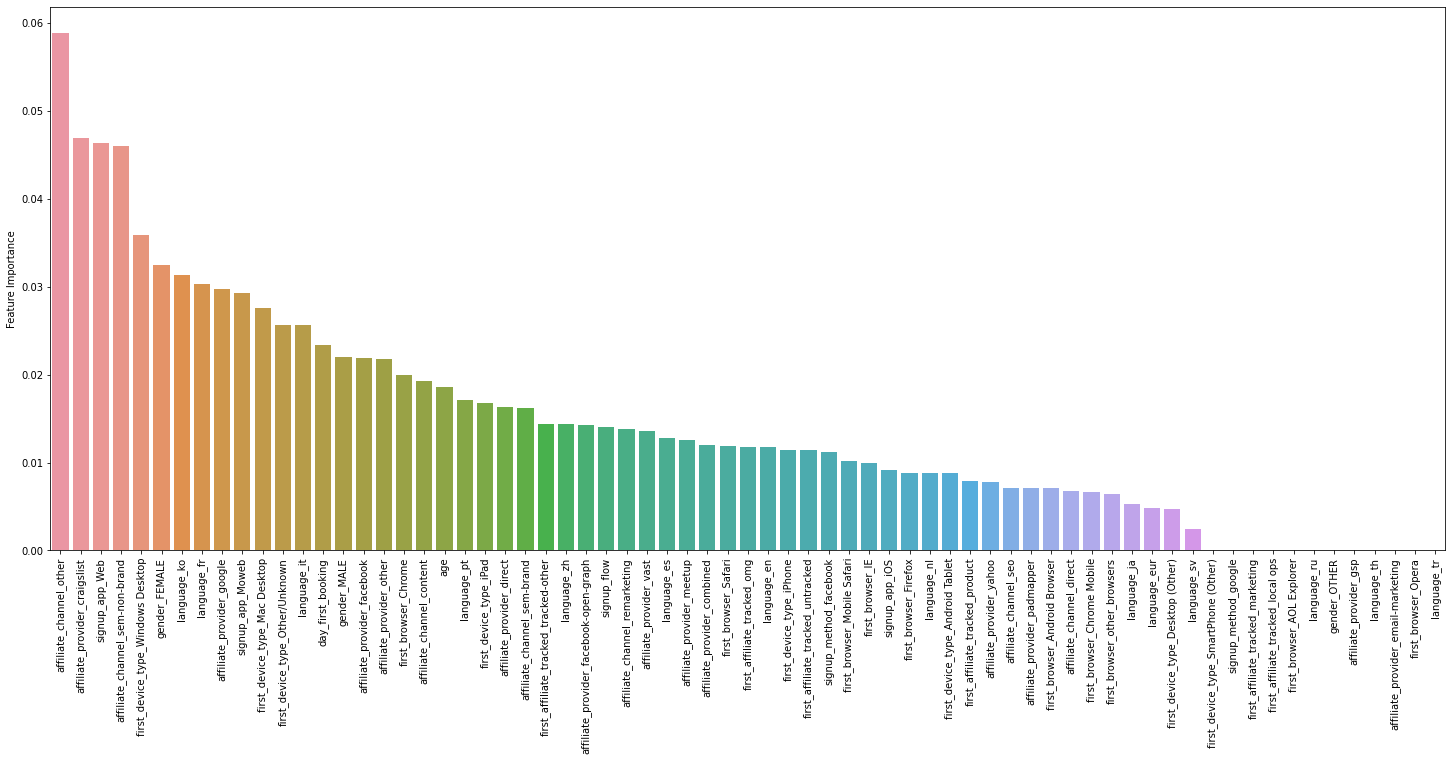

In [234]:
import seaborn as sns

feat_imp = pd.DataFrame(data=xgb_6_full.feature_importances_, index=total[total.train == 1].drop(["train"], axis=1).columns, columns=["Feature Importance"])
feat_imp = feat_imp.sort_values(by="Feature Importance", ascending=False)
plt.figure(figsize=(25, 10))
sns.barplot(x=feat_imp.index, y=feat_imp["Feature Importance"])
plt.xticks(rotation=90)

In [257]:
to_csv(xgb_6_full, "xgb_6_full_corrected")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### NDF Test

In [271]:
total[total.train==1]

age  signup_flow  ...  first_browser_Safari  first_browser_other_browsers
2       56.0            3  ...                     0                             0
3       42.0            0  ...                     0                             0
4       41.0            0  ...                     0                             0
5       34.0            0  ...                     0                             0
6       46.0            0  ...                     1                             0
...      ...          ...  ...                   ...                           ...
170118  27.0            0  ...                     0                             0
170122  76.0            0  ...                     0                             0
170125  38.0            0  ...                     0                             0
170128  51.0            0  ...                     0                             0
170134  32.0            0  ...                     0                             0

[72330 rows x 70 columns]

In [273]:
test_copy

id date_first_booking  ... train  day_first_booking
0      f3g7ae12j0                NaT  ...     0                NaN
1      ks0uq0sd8x         2014-04-01  ...     0               91.0
2      8w236a1unv                NaT  ...     0                NaN
3      vd221xgcu6         2014-04-01  ...     0               91.0
4      bt5x8x87wu         2014-04-01  ...     0               91.0
...           ...                ...  ...   ...                ...
43309  zxodksqpep                NaT  ...     0                NaN
43310  mhewnxesx9                NaT  ...     0                NaN
43311  6o3arsjbb4                NaT  ...     0                NaN
43312  jh95kwisub                NaT  ...     0                NaN
43313  nw9fwlyb5f                NaT  ...     0                NaN

[43314 rows x 15 columns]

In [295]:
test_total

age  signup_flow  ... first_browser_Safari  first_browser_other_browsers
0      34.0            0  ...                    0                             0
1      38.0            0  ...                    0                             0
2      56.0            3  ...                    0                             0
3      42.0            0  ...                    0                             0
4      41.0            0  ...                    0                             0
...     ...          ...  ...                  ...                           ...
43309  32.0            0  ...                    1                             0
43310  31.0            0  ...                    0                             0
43311  32.0            0  ...                    0                             0
43312  31.0           25  ...                    0                             0
43313  31.0           25  ...                    0                             0

[213451 rows x 72 columns]

In [310]:
ndf_x_train = test_total[test_total.train==1].drop(["train"], axis =1).dropna().drop(["day_first_booking", "country_destination"], axis=1)
ndf_x_test = test_total[test_total.train==0].drop(["train", "day_first_booking", "country_destination"], axis =1)
scaler_tr_ndf = StandardScaler()
scaler_ts_ndf = StandardScaler()
ndf_x_train = scaler_tr_ndf.fit_transform(ndf_x_train)
ndf_x_test = scaler_ts_ndf.fit_transform(ndf_x_test)

In [311]:
from sklearn.model_selection import train_test_split
xtr_ndf, xvl_ndf, ytr_ndf, yvl_ndf = train_test_split(ndf_x_train, y, stratify=y, random_state = 420)

#### XGB

In [312]:
# bet even far
from xgboost import XGBClassifier
params_ndf = {
    "learning_rate": 0.07,
    "n_estimators": 240,
    "max_depth": 2,
    "min_child_weight": 5,
    "gamma": 0.2,
    "objective":  'multi:softprob',
    "nthread": -1,
    "reg_alpha":  0.6,
    "seed": 42,
    "n_jobs": -1,
    "silent": 0,
}
xgb_ndf = XGBClassifier(**params_ndf)
xgb_ndf.fit(xtr_ndf, ytr_ndf, eval_metric="mlogloss", eval_set=[(xtr_ndf, ytr_ndf), (xvl_ndf, yvl_ndf)])

[0]	validation_0-mlogloss:2.22214	validation_1-mlogloss:2.22241
[1]	validation_0-mlogloss:2.08961	validation_1-mlogloss:2.09001
[2]	validation_0-mlogloss:1.98364	validation_1-mlogloss:1.98407
[3]	validation_0-mlogloss:1.8958	validation_1-mlogloss:1.89625
[4]	validation_0-mlogloss:1.82119	validation_1-mlogloss:1.82168
[5]	validation_0-mlogloss:1.75676	validation_1-mlogloss:1.7573
[6]	validation_0-mlogloss:1.70049	validation_1-mlogloss:1.70109
[7]	validation_0-mlogloss:1.65095	validation_1-mlogloss:1.65153
[8]	validation_0-mlogloss:1.60684	validation_1-mlogloss:1.60748
[9]	validation_0-mlogloss:1.56744	validation_1-mlogloss:1.56817
[10]	validation_0-mlogloss:1.53211	validation_1-mlogloss:1.53281
[11]	validation_0-mlogloss:1.50022	validation_1-mlogloss:1.50094
[12]	validation_0-mlogloss:1.47137	validation_1-mlogloss:1.47215
[13]	validation_0-mlogloss:1.44522	validation_1-mlogloss:1.44603
[14]	validation_0-mlogloss:1.42141	validation_1-mlogloss:1.42224
[15]	validation_0-mlogloss:1.39976	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.07, max_delta_step=0, max_depth=2,
              min_child_weight=5, missing=None, n_estimators=240, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=0, subsample=1, verbosity=1)

In [317]:
xgb_ndf_full = XGBClassifier(**{
    "learning_rate": 0.07,
    "n_estimators": 240,
    "max_depth": 2,
    "min_child_weight": 5,
    "gamma": 0.2,
    "objective":  'multi:softprob',
    "nthread": -1,
    "reg_alpha":  0.6,
    "seed": 42,
    "n_jobs": -1,
    "silent": 0,
})
xgb_ndf_full.fit(ndf_x_train, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.07, max_delta_step=0, max_depth=2,
              min_child_weight=5, missing=None, n_estimators=240, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=0, subsample=1, verbosity=1)

In [267]:
test_copy[["id"]]

id
0      f3g7ae12j0
1      ks0uq0sd8x
2      8w236a1unv
3      vd221xgcu6
4      bt5x8x87wu
...           ...
43309  zxodksqpep
43310  mhewnxesx9
43311  6o3arsjbb4
43312  jh95kwisub
43313  nw9fwlyb5f

[43314 rows x 1 columns]

In [360]:
notnull_test_ndf = test_copy[["id"]]

# null_test_ndf['country_destination'] = "NDF"


notnull_test_ndf['country_destination'] = ''

top_predictions = np.apply_along_axis(le.inverse_transform, 1, np.flip(np.argsort(xgb_ndf_full.predict_proba(ndf_x_test))[:, -3:]))

# null_test_ndf = null_test_ndf[['id', 'country_destination']]

out_nonNDF_ndf = pd.DataFrame(np.repeat(notnull_test_ndf.values, 3, axis=0), columns=notnull_test_ndf.columns)
out_nonNDF_ndf["country_destination"] = top_predictions.flatten()

null_idval = null_test["id"].values 
# out_nonNDF_ndf
# ndf_x_test.shape


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [357]:
out_nonNDF_ndf

id country_destination
0       f3g7ae12j0                  US
1       f3g7ae12j0               other
2       f3g7ae12j0                  FR
3       ks0uq0sd8x                  US
4       ks0uq0sd8x               other
...            ...                 ...
129937  jh95kwisub               other
129938  jh95kwisub                  FR
129939  nw9fwlyb5f                  US
129940  nw9fwlyb5f               other
129941  nw9fwlyb5f                  FR

[129942 rows x 2 columns]

In [361]:
null_idval

array(['f3g7ae12j0', '8w236a1unv', 'v2jgdc51bs', ..., '6o3arsjbb4',
       'jh95kwisub', 'nw9fwlyb5f'], dtype=object)

In [366]:
ids = (out_nonNDF_ndf[["id"]].values)
countries = out_nonNDF_ndf[["country_destination"]].values

for idx, val in enumerate(out_nonNDF_ndf[["country_destination"]].values):
  if idx%3 == 0:
    if ids[idx][0] in null_idval:
      temp_ctr_1, temp_ctr_2 = (countries[idx][0], countries[idx+1][0])
      out_nonNDF_ndf.country_destination[idx] = "NDF"
      out_nonNDF_ndf.country_destination[idx+1] = temp_ctr_1
      out_nonNDF_ndf.country_destination[idx+2] = temp_ctr_2

In [371]:
out_nonNDF_ndf

id country_destination
0       f3g7ae12j0                 NDF
1       f3g7ae12j0                  US
2       f3g7ae12j0               other
3       ks0uq0sd8x                  US
4       ks0uq0sd8x               other
...            ...                 ...
129937  jh95kwisub                  US
129938  jh95kwisub               other
129939  nw9fwlyb5f                 NDF
129940  nw9fwlyb5f                  US
129941  nw9fwlyb5f               other

[129942 rows x 2 columns]

In [368]:
null_test = test_copy[test_copy.date_first_booking.isna()]
notnull_test = test_copy[test_copy.date_first_booking.notna()]
null_test['country_destination'] = "NDF"
notnull_test["country_destination"] = ''
top_predictions = np.apply_along_axis(le.inverse_transform, 1, np.flip(np.argsort(xgb_6_full.predict_proba(X_test))[:, -3:]))
notnull_test = notnull_test[['id', 'country_destination']]
out_nonNDF = pd.DataFrame(np.repeat(notnull_test.values, 3, axis=0), columns=notnull_test.columns)
out_nonNDF["country_destination"] = top_predictions.flatten()
null_test = null_test[["id", "country_destination"]]
out_ndf = pd.DataFrame(np.repeat(null_test.values, 3, axis=0), columns=null_test.columns)

out = pd.concat([out_ndf, out_nonNDF])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [412]:
out_nonNDF_ndf.reset_index().drop(["MyIdx"], axis=1)

id country_destination
0       zzzlylp57e                  US
1       zzzlylp57e               other
2       zzzlylp57e                  FR
3       zzx5wp3lqu                 NDF
4       zzx5wp3lqu                  US
...            ...                 ...
129937  001wyh0pz8                  US
129938  001wyh0pz8               other
129939  00023iyk9l                  US
129940  00023iyk9l               other
129941  00023iyk9l                  FR

[129942 rows x 2 columns]

In [413]:
out

id country_destination
0       zzzlylp57e                  US
1       zzzlylp57e                  FR
2       zzzlylp57e               other
3       zzx5wp3lqu                 NDF
4       zzx5wp3lqu                 NDF
...            ...                 ...
129937  001wyh0pz8                 NDF
129938  001wyh0pz8                 NDF
129939  00023iyk9l                  US
129940  00023iyk9l               other
129941  00023iyk9l                  FR

[129942 rows x 2 columns]

In [414]:
out = out.rename_axis('MyIdx').sort_values(by = ['id', 'MyIdx'], ascending = [False, True]).reset_index().drop(["MyIdx"], axis=1)
out_nonNDF_ndf = out_nonNDF_ndf.rename_axis('MyIdx').sort_values(by = ['id', 'MyIdx'], ascending = [False, True]).reset_index().drop(["MyIdx"], axis=1)

In [418]:
out['ndfctr'] = out_nonNDF_ndf.country_destination

In [429]:
for i in out.index:
  if i%3 != 0:
    if out.loc[i].country_destination == "NDF":
      out.at[i, 'country_destination'] = out.loc[i].ndfctr

In [427]:
out

id country_destination ndfctr
0       zzzlylp57e                  US     US
1       zzzlylp57e                  FR  other
2       zzzlylp57e               other     FR
3       zzx5wp3lqu                 NDF    NDF
4       zzx5wp3lqu                 NDF     US
...            ...                 ...    ...
129937  001wyh0pz8                 NDF     US
129938  001wyh0pz8                 NDF  other
129939  00023iyk9l                  US     US
129940  00023iyk9l               other  other
129941  00023iyk9l                  FR     FR

[129942 rows x 3 columns]

In [431]:
out.drop(["ndfctr"], axis=1, inplace=True)

In [432]:
out

id country_destination
0       zzzlylp57e                  US
1       zzzlylp57e                  FR
2       zzzlylp57e               other
3       zzx5wp3lqu                 NDF
4       zzx5wp3lqu                  US
...            ...                 ...
129937  001wyh0pz8                  US
129938  001wyh0pz8               other
129939  00023iyk9l                  US
129940  00023iyk9l               other
129941  00023iyk9l                  FR

[129942 rows x 2 columns]

In [434]:
out.to_csv("xgb country added to duplicate NDF.csv", index=False)

---
# END

---

In [323]:
null_test = test_copy[test_copy.date_first_booking.isna()][["id"]]

In [338]:
null_test["id"].values 

array(['f3g7ae12j0', '8w236a1unv', 'v2jgdc51bs', ..., '6o3arsjbb4',
       'jh95kwisub', 'nw9fwlyb5f'], dtype=object)

In [254]:
full_test_ndf = get_top_countries(xgb_ndf_full.predict_proba(ndf_x_test), 2)

ndf_id = test_copy[["id"]]
notnull_test_ndf = test_copy[["id"]

# null_test_ndf['country_destination'] = "NDF"
notnull_test_ndf['country_destination'] = ''

top_predictions = np.apply_along_axis(le.inverse_transform, 1, np.flip(np.argsort(xgb_ndf_full.predict_proba(X_test))[:, -3:]))

# null_test_ndf = null_test_ndf[['id', 'country_destination']]

out_nonNDF_ndf = pd.DataFrame(np.repeat(notnull_test_ndf.values, 3, axis=0), columns=notnull_test_ndf.columns)
out_nonNDF_ndf["country_destination"] = top_predictions.flatten()

null_test_ndf = null_test_ndf[["id", "country_destination"]]

out_ndf_ndf = pd.DataFrame(np.repeat(null_test.values, 3, axis=0), columns=null_test.columns)

# out = pd.concat([out_ndf_ndf, out_nonNDF_ndf])
# out.to_csv(filename+".csv", index=False)

array([['US', 'other'],
       ['US', 'other'],
       ['US', 'other'],
       ...,
       ['US', 'other'],
       ['US', 'other'],
       ['US', 'other']], dtype=object)

In [214]:
from sklearn.model_selection import StratifiedKFold
my_ndcg_score(yvl, xgb_1.predict_proba(xvl))

0.6844714269834802

In [215]:
my_ndcg_score(yvl, xgb_2.predict_proba(xvl))

0.6689498709214245

In [216]:
my_ndcg_score(yvl, xgb_3.predict_proba(xvl))

0.6686405911616503

In [166]:
xgb_full = XGBClassifier(**params)
xgb_full.fit(X_train, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=4, missing=None, n_estimators=30, n_jobs=-1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=0, subsample=1, verbosity=1)

In [ ]:
xgb_full.

In [164]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=42)

In [165]:
rf.fit(xtr, ytr)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
log_loss(get_true_y)

In [125]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, auc, recall_score, log_loss
import parfit.parfit as pf
grid = {
    "learning_rate": [0.03, 0.1], 
    "n_estimators": [50, 100, 200],
    "max_depth": [2, 4, 6],
    # "min_child_weight": [9],
    "gamma": [0.2],
    "objective":  ['multi:softprob'],
    "nthread": [-1],
    "reg_alpha":  [0.6],
    "seed": [42],
    "n_jobs": [-1],
    "silent": [0],
    # "eval_metric": ["mlogloss"]
}
paramGrid = ParameterGrid(grid)

bestXGModel, bestXGScore, allXGModels, allXGScores = pf.bestFit(XGBClassifier, paramGrid,
           xtr, ytr, nfolds=2,
           metric = log_loss,
           scoreLabel = "log_loss")

print(bestXGModel, bestXGScore)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 32.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------SCORING MODELS-------------


IndexError: ignored

In [147]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, auc, recall_score, log_loss
import parfit.parfit as pf
grid = {
    "learning_rate": 0.1, 
    "n_estimators": 50,
    "max_depth": 6,
    # "min_child_weight": 9,
    "gamma": 0.2,
    "objective":  'multi:softprob',
    "nthread": -1,
    "reg_alpha":  0.6,
    "seed": 42,
    "n_jobs": -1,
    "silent": 0,
    "eval_metric": "mlogloss"
}
trying = XGBClassifier(**grid)

In [258]:
# get_top_countries(bnb.predict_proba(X_test), 3)

NameError: ignored

In [284]:
from sklearn.tree import DecisionTreeClassifier
dcf = DecisionTreeClassifier()
dcf.fit(X_train, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [287]:
dcf.predict_proba(X_test)

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
np.unique(bnb.predict(X_test))

array([ 0,  4,  6,  7,  8,  9, 10])

In [ ]:
model.fit(X_train, Y_train.country_destination.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
np.unique(model.predict(X_test))

array(['US'], dtype=object)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=42)

In [ ]:
ypred=classifier.fit(X_train, y)

In [168]:
ypr_prob = xgb_full.predict_proba(X_test)
# ypr = ypred.predict(X_test)

In [169]:
ypr_prob[0]

array([0.01608214, 0.02367821, 0.01919039, 0.03416427, 0.03623929,
       0.02637203, 0.03127023, 0.01975981, 0.01480933, 0.69202   ,
       0.08641436], dtype=float32)

In [170]:
np.unique(ypr)

NameError: ignored

In [ ]:
samp

id country_destination
0       f3g7ae12j0                 NDF
1       f3g7ae12j0                 NDF
2       f3g7ae12j0                 NDF
3       ks0uq0sd8x                 NDF
4       ks0uq0sd8x                 NDF
...            ...                 ...
129937  jh95kwisub                 NDF
129938  jh95kwisub                 NDF
129939  nw9fwlyb5f                 NDF
129940  nw9fwlyb5f                 NDF
129941  nw9fwlyb5f                 NDF

[129942 rows x 2 columns]

In [171]:
null_test = test_copy[test_copy.date_first_booking.isna()]
notnull_test = test_copy[test_copy.date_first_booking.notna()]

In [172]:
test_copy.id

0        f3g7ae12j0
1        ks0uq0sd8x
2        8w236a1unv
3        vd221xgcu6
4        bt5x8x87wu
            ...    
43309    zxodksqpep
43310    mhewnxesx9
43311    6o3arsjbb4
43312    jh95kwisub
43313    nw9fwlyb5f
Name: id, Length: 43314, dtype: object

In [ ]:
test_ids

NameError: ignored

In [ ]:
le.inverse_transform(ypr)

array(['US', 'US', 'US', ..., 'US', 'US', 'US'], dtype=object)

In [180]:
null_test['country_destination'] = "NDF"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [173]:
# le.inverse_transform()
# top_idx = 
top_idx = np.flip(np.argsort(ypr_prob)[:, -3:])
# ypr_prob[0]
le.inverse_transform(top_idx[0])

array(['US', 'other', 'FR'], dtype=object)

In [174]:
top_ctr = np.apply_along_axis(le.inverse_transform, 1, top_idx)

array(['US', 'IT', 'other', ..., 'US', 'IT', 'AU'], dtype=object)

In [175]:
notnull_test["country_destination"] = ''

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [176]:
notnull_test = notnull_test[['id', 'country_destination']]

In [177]:
out_nonNDF = pd.DataFrame(np.repeat(notnull_test.values,3,axis=0), columns=notnull_test.columns)

In [178]:
out_nonNDF["country_destination"] = top_ctr.flatten()
out_nonNDF

id country_destination
0      ks0uq0sd8x                  US
1      ks0uq0sd8x               other
2      ks0uq0sd8x                  FR
3      vd221xgcu6                  US
4      vd221xgcu6               other
...           ...                 ...
49729  0k26r3mir0               other
49730  0k26r3mir0                  FR
49731  qbxza0xojf                  US
49732  qbxza0xojf               other
49733  qbxza0xojf                  FR

[49734 rows x 2 columns]

In [181]:
null_test = null_test[["id", "country_destination"]]
out_ndf = pd.DataFrame(np.repeat(null_test.values,3,axis=0), columns=null_test.columns)

In [182]:
out = pd.concat([out_ndf, out_nonNDF])

In [183]:
out

id country_destination
0      f3g7ae12j0                 NDF
1      f3g7ae12j0                 NDF
2      f3g7ae12j0                 NDF
3      8w236a1unv                 NDF
4      8w236a1unv                 NDF
...           ...                 ...
49729  0k26r3mir0               other
49730  0k26r3mir0                  FR
49731  qbxza0xojf                  US
49732  qbxza0xojf               other
49733  qbxza0xojf                  FR

[129942 rows x 2 columns]

In [184]:
out.to_csv("xgb30_0.1.csv", index=False)

In [256]:
def to_csv(model, filename):

  null_test = test_copy[test_copy.date_first_booking.isna()]
  notnull_test = test_copy[test_copy.date_first_booking.notna()]

  null_test['country_destination'] = "NDF"
  notnull_test["country_destination"] = ''
  
  top_predictions = np.apply_along_axis(le.inverse_transform, 1, np.flip(np.argsort(model.predict_proba(X_test))[:, -3:]))

  notnull_test = notnull_test[['id', 'country_destination']]
  
  out_nonNDF = pd.DataFrame(np.repeat(notnull_test.values, 3, axis=0), columns=notnull_test.columns)
  out_nonNDF["country_destination"] = top_predictions.flatten()

  null_test = null_test[["id", "country_destination"]]
  
  out_ndf = pd.DataFrame(np.repeat(null_test.values, 3, axis=0), columns=null_test.columns)
  
  out = pd.concat([out_ndf, out_nonNDF])
  out.to_csv(filename+".csv", index=False)

In [200]:
to_csv(xgb_full, "lmao tet")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

